In [1]:
import sys
import pandas as pd
from load_data import get_data
from processing_helpers import get_cue_segments, get_power_spec, get_peak_fits
from tally_helper import TallyWindow
# from plot_window import plot_processing
import pickle as pkl
import numpy as np
import DataProcessingTools as DPT
import os
import matplotlib.pyplot as plt
from fooof import FOOOF
from ipywidgets import widgets, HBox, VBox, Output
from scipy.stats import sem, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
# Global variables to store the session data
lfp_df = pd.DataFrame()
ch_num_list = []
lfp_mne = []
session_start_time = 0
markers = []
timeStamps = []
sampling_frequency = 0
segments_df = pd.DataFrame()


In [3]:
def load_data(day):
    """
    Load LFP data for a given day.
    """
    global lfp_df, ch_num_list, lfp_mne, session_start_time, markers, timeStamps, sampling_frequency
    print(f"Loading data for {day}...")
    lfp_df, ch_num_list, lfp_mne, session_start_time, markers, timeStamps, sampling_frequency = get_data(day)

    if lfp_df is not None:
        print(f"Loaded {len(ch_num_list)} channels.")
        print(lfp_df.head())
    else:
        print("Failed to load data.")


def load_pkl(file_path):
    """
    Load segments DataFrame from a Pickle file.
    """
    global segments_df
    try:
        with open(file_path, 'rb') as file:
            segments_df = pkl.load(file)
        print(f"Data successfully loaded from {file_path}")
        print(f"Loaded data has {segments_df.shape[0]} rows and {segments_df.shape[1]} columns.")
        print(segments_df.head())
    except Exception as e:
        print(f"Failed to load data: {str(e)}")


def save_pkl(file_path):
    """
    Save the current segments DataFrame to a Pickle file.
    """
    if segments_df.empty:
        print("No data available to export.")
        return

    try:
        if not file_path.endswith('.pkl'):
            file_path += '.pkl'

        with open(file_path, 'wb') as file:
            pkl.dump(segments_df, file)
        print(f"Data successfully exported to {file_path}")
    except Exception as e:
        print(f"Failed to export data: {str(e)}")


def get_segment(window_size, method='welch', max_n_peaks=3, peak_threshold=2, peak_fit_range=[1,12]):
    """
    Extract segments from the LFP data using the specified window size.
    """
    global segments_df

    if lfp_df.empty or not markers or not timeStamps:
        print("Please load data before extracting segments.")
        return

    segments_df = get_cue_segments(lfp_df, markers, timeStamps, window_size=window_size)
    print(f"Extracted {len(segments_df)} segments.")

    frequencies = []
    psd_list = []
    p_stds_l = []
    p_means_l = []
    peak_gauss_l = []
    flat_spec_l = []
    flat_spec_og_l = []
    ap_fit_og_l = []
    peaks_l, peak_freqs_l = [], []

    count = 0
    segments_list = segments_df['segment'].values  # Convert df to array for faster processing

    for segment in segments_list:
        freq, psd = get_power_spec(segment, sampling_frequency, method=method)
        frequencies.append(freq)


        psd, ap_fit_og, flat_spec_og, p_stds, p_means, peak_gauss, flat_specs, peaks, peak_freqs= get_peak_fits(psd, freq, peak_fit_range, max_n_peaks=max_n_peaks, peak_threshold=peak_threshold)
        psd_list.append(psd)
        p_stds_l.append(p_stds)
        p_means_l.append(p_means)
        peak_gauss_l.append(peak_gauss)
        flat_spec_l.append(flat_specs)
        flat_spec_og_l.append(flat_spec_og)
        ap_fit_og_l.append(ap_fit_og)
        peaks_l.append(peaks)
        peak_freqs_l.append(peak_freqs)

        count += 1
        print(f"Processed segment {count}")

    segments_df['psd'] = psd_list
    segments_df['freq'] = frequencies
    segments_df['peak_stds'] = p_stds_l
    segments_df['peak_means'] = p_means_l
    segments_df['peak_gauss'] = peak_gauss_l
    segments_df['flat_specs'] = flat_spec_l
    segments_df['flat_spec_og'] = flat_spec_og_l
    segments_df['ap_fit_og'] = ap_fit_og_l
    segments_df['peaks'] = peaks_l
    segments_df['peak_freqs'] = peak_freqs_l
    print("Segments processed successfully.")

def show_tally():
    """
    Display tally information for the segments DataFrame.
    """
    if segments_df.empty:
        print("Please generate segments before viewing the tally.")
        return

    # Example of tally logic; customize as needed
    print("Tally of segments by channel:")
    print(segments_df.groupby('channel').size())
    TallyWindow(segments_df, ch_num_list).show()


In [4]:
# Load Raw Data
day = "20181105"
load_data(day)

Loading data for 20181105...
Creating RawArray with float64 data, n_channels=26, n_times=5496020
    Range : 0 ... 5496019 =      0.000 ...  5496.019 secs
Ready.
Loaded 26 channels.
  channel                                           lfp_data
0     009  [-15.689277, -63.415035, -97.32542, -110.48099...
1     019  [-7.3521805, -22.254305, -32.18146, -35.23267,...
2     021  [-7.631544, -1.5259957, 3.660045, 8.1869755, 1...
3     022  [-56.752617, -77.27964, -92.39461, -100.60819,...
4     023  [32.315643, 41.446926, 46.777287, 46.48198, 41...


In [5]:
# Extract segments with a specific window size and process
window_size = 1000  # e.g., 1000 ms
peak_fit_range = [1,14]
get_segment(window_size, method='welch', max_n_peaks=3, peak_threshold=1.76, peak_fit_range=peak_fit_range)

Extracted 10374 segments.
Processed segment 1
Processed segment 2
Processed segment 3
Processed segment 4
Processed segment 5
Processed segment 6
Processed segment 7
Processed segment 8
Processed segment 9
Processed segment 10
Processed segment 11
Processed segment 12
Processed segment 13
Processed segment 14
Processed segment 15
Processed segment 16
Processed segment 17
Processed segment 18
Processed segment 19
Processed segment 20
Processed segment 21
Processed segment 22
Processed segment 23
Processed segment 24
Processed segment 25
Processed segment 26
Processed segment 27
Processed segment 28
Processed segment 29
Processed segment 30
Processed segment 31
Processed segment 32
Processed segment 33
Processed segment 34
Processed segment 35
Processed segment 36
Processed segment 37
Processed segment 38
Processed segment 39
Processed segment 40
Processed segment 41
Processed segment 42
Processed segment 43
Processed segment 44
Processed segment 45
Processed segment 46
Processed segment

In [ ]:
# save_pkl(f"Data Processed/{day}_1s_welch.pkl")


In [ ]:
# seg_len = 1
# method = "welch"

# path = f"Data Processed/{day}_{seg_len}s_{method}_.pkl"

# if os.path.exists(path):    
#     # Load segments from a Pickle file    
#     load_pkl(path)

# else: 
#     # Save the processed segments to a Pickle file
#     save_pkl(path)

# # Show tally information
# show_tally()

/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_3115/1026498557.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 4, figsize=(15, 4))


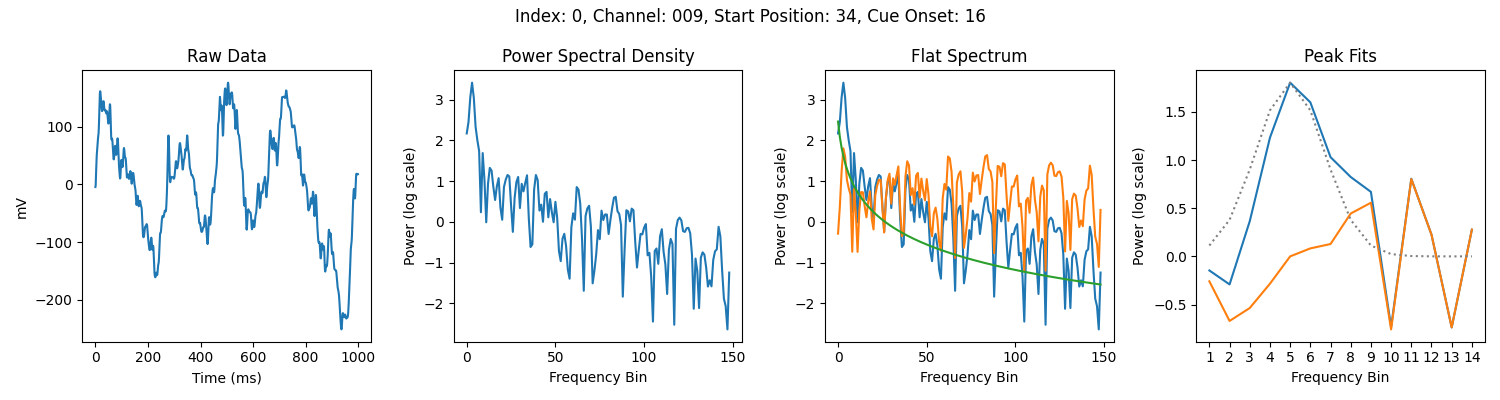

/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_3115/1026498557.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_3115/1026498557.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_3115/1026498557.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_3115/1026498557.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_3115/1026498557.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/var/folders/wp/fswmwrqd72bd11561bb9cztm0000h2/T/ipykernel_3115/1026498557.py:57: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [11]:
# Activate interactive plotting in Jupyter Notebook
%matplotlib widget

# Initial index
current_index = [0]

# Create the figure and axis
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
ax = ax.flatten()

# Function to update the plot
def update_plot(index):
    ch = segments_df.iloc[index]["channel"]
    start_pos = segments_df.iloc[index]["start_position"]
    cue_onset = segments_df.iloc[index]["cue_onset"]

    ax[0].clear()
    ax[0].plot(segments_df.iloc[index]['segment'])
    ax[0].set_title("Raw Data")
    ax[0].set_xlabel("Time (ms)")
    ax[0].set_ylabel("mV")

    ax[1].clear()
    ax[1].plot(segments_df.iloc[index]['psd'][1:150])
    ax[1].set_title("Power Spectral Density")
    ax[1].set_xlabel("Frequency Bin")
    ax[1].set_ylabel("Power (log scale)")

    ax[2].clear()
    ax[2].plot(segments_df.iloc[index]['psd'][1:150])
    ax[2].plot(segments_df.iloc[index]['flat_spec_og'][1:150])
    ax[2].plot(segments_df.iloc[index]['ap_fit_og'][1:150])
    ax[2].set_title("Flat Spectrum")
    ax[2].set_xlabel("Frequency Bin")
    ax[2].set_ylabel("Power (log scale)")


    ax[3].clear()
    x_values = segments_df['freq'][0][peak_fit_range[0]:peak_fit_range[1]+1]
    ax[3].plot(segments_df['freq'][0][peak_fit_range[0]:peak_fit_range[1]+1], segments_df.iloc[index]['flat_specs'][0])

    for i in range(len(segments_df.iloc[index]['peak_gauss'])):
        freq_values = segments_df['freq'][i][peak_fit_range[0]:peak_fit_range[1]+1]
        ax[3].plot(freq_values, segments_df.iloc[index]['flat_specs'][i+1])
        ax[3].plot(freq_values, segments_df.iloc[index]['peak_gauss'][i], linestyle=":", color="grey")

    # Setting titles and labels
    ax[3].set_title("Peak Fits")
    ax[3].set_xlabel("Frequency Bin")
    ax[3].set_ylabel("Power (log scale)")

    # Set x-axis ticks to steps of 1
    ax[3].set_xticks(np.arange(min(x_values), max(x_values)+1, 1))

    # Adjust layout and redraw
    fig.suptitle(f"Index: {index}, Channel: {ch}, Start Position: {start_pos}, Cue Onset: {cue_onset}")
    fig.tight_layout()
    fig.canvas.draw_idle()

# Function to sort the DataFrame based on selected column
def sort_segments(order_by):
    global segments_df
    global sorted_indices
    segments_df.sort_values(by=order_by, inplace=True)
    segments_df.reset_index(drop=True, inplace=True)
    sorted_indices = list(range(len(segments_df)))
    current_index[0] = 0
    update_plot(current_index[0])
    index_input.value = str(current_index[0])

# Initial plot
update_plot(current_index[0])

# Event handler for key press
def on_key(event):
    if event.key == 'right':  # Navigate forward
        current_index[0] = (current_index[0] + 1) % len(segments_df)
    elif event.key == 'left':  # Navigate backward
        current_index[0] = (current_index[0] - 1) % len(segments_df)
    update_plot(current_index[0])
    index_input.value = str(current_index[0])  # Sync text input with current index

# Connect key press events
fig.canvas.mpl_connect('key_press_event', on_key)

# Create a text box for index input
index_input = widgets.Text(
    value=str(current_index[0]),
    description="Index:",
    style={"description_width": "initial"}
)

# Function to handle text input
def on_text_submit(change):
    try:
        new_index = int(change["new"])
        if 0 <= new_index < len(segments_df):
            current_index[0] = new_index
            update_plot(current_index[0])
        else:
            index_input.value = str(current_index[0])  # Reset to current index if invalid
    except ValueError:
        index_input.value = str(current_index[0])  # Reset to current index if invalid

# Attach the handler to text input
index_input.observe(on_text_submit, names="value")

# Dropdown menu for sorting
sort_dropdown = widgets.Dropdown(
    options=['channel', 'start_position', 'cue_onset'],
    description='Sort by:',
    style={"description_width": "initial"}
)

# Function to handle dropdown selection
def on_sort_change(change):
    sort_segments(change["new"])

# Attach the handler to dropdown
sort_dropdown.observe(on_sort_change, names="value")

# Display the text input, dropdown, and plot
ui = VBox([HBox([index_input, sort_dropdown])])
display(ui)
plt.show()

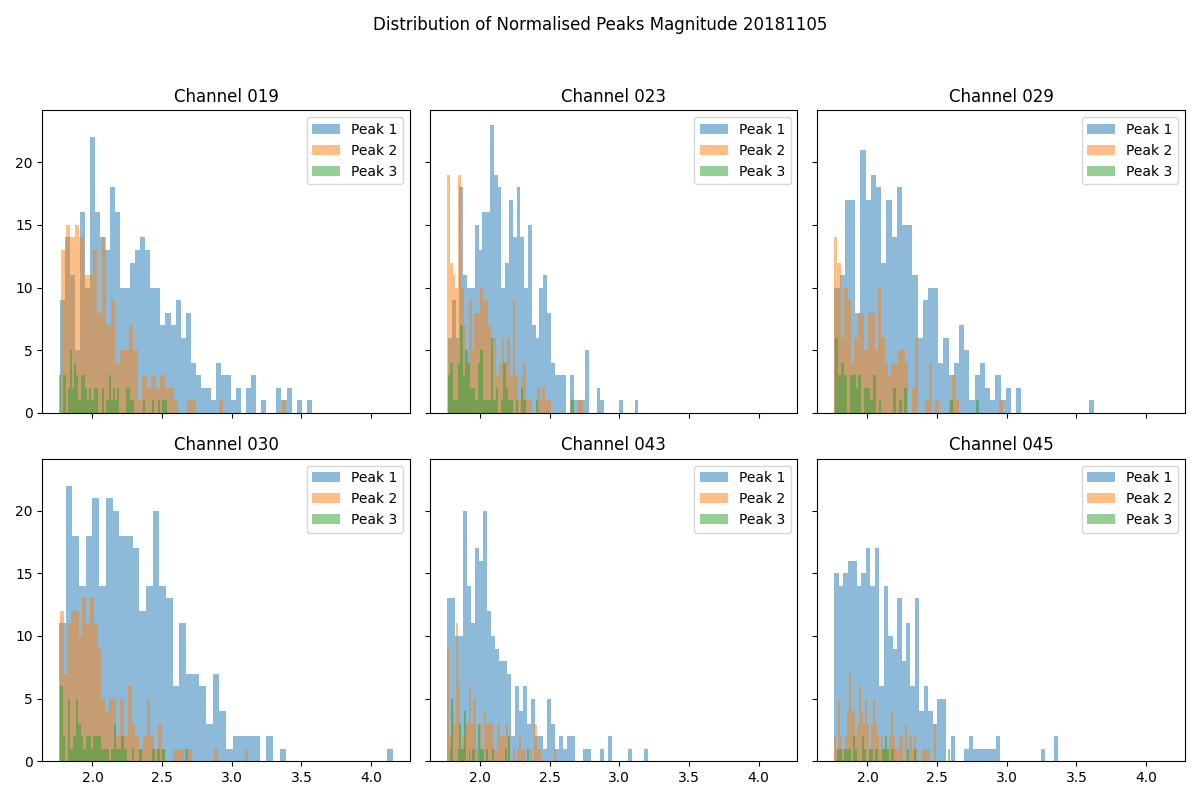

In [7]:
channels_of_interest = ["019", "023", "029", "030", "043", "045"]

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, ch in enumerate(channels_of_interest):
    filtered_df = segments_df[segments_df['channel'] == ch]

    peak_stds = filtered_df['peak_stds'].apply(pd.Series)
    peaks = filtered_df['peaks'].apply(pd.Series)
    peak_means = filtered_df['peak_means'].apply(pd.Series)  # Split into separate columns

    for col in peak_means.columns:
        normalised_peaks = (peaks[col])/peak_stds[col]
        axes[i].hist(normalised_peaks, bins=50, alpha=0.5, label=f'Peak {col+1}')
    
    axes[i].set_title(f'Channel {ch}')
    axes[i].legend()

fig.suptitle(f"Distribution of Normalised Peaks Magnitude {day}")
fig.tight_layout(rect=[0, 0, 1, 0.95])



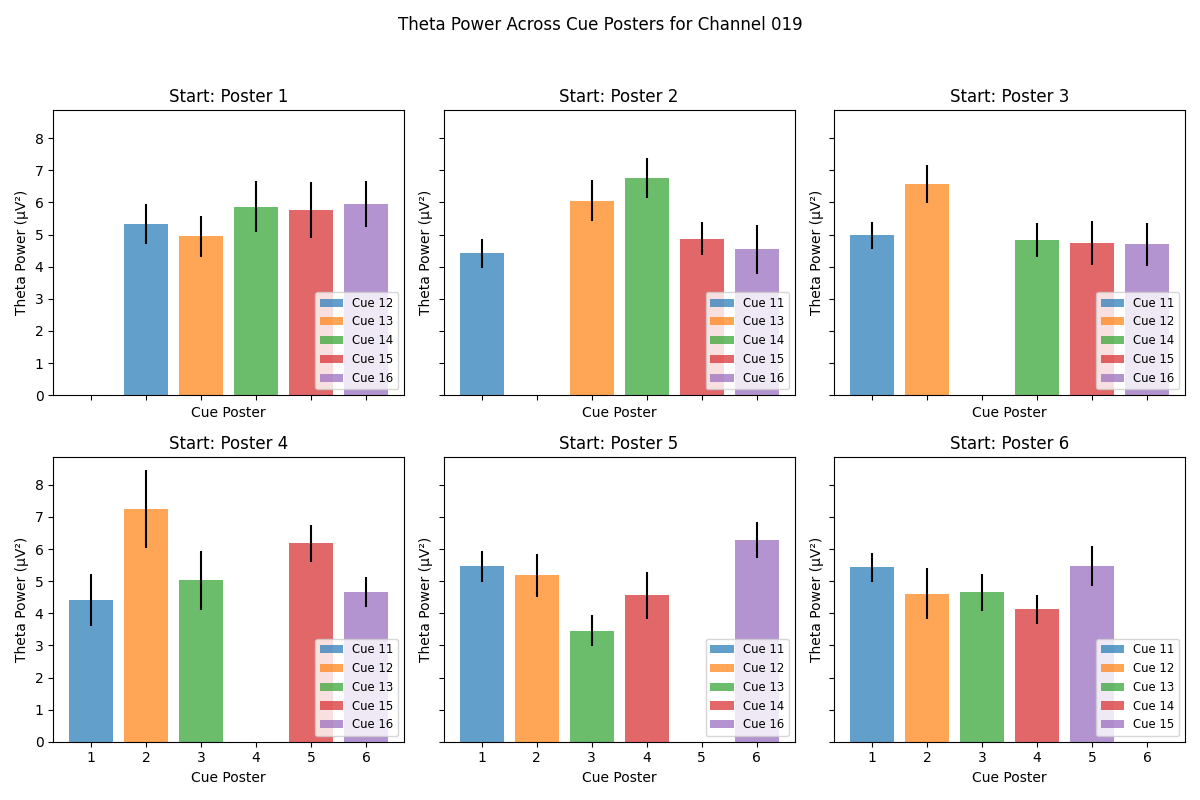

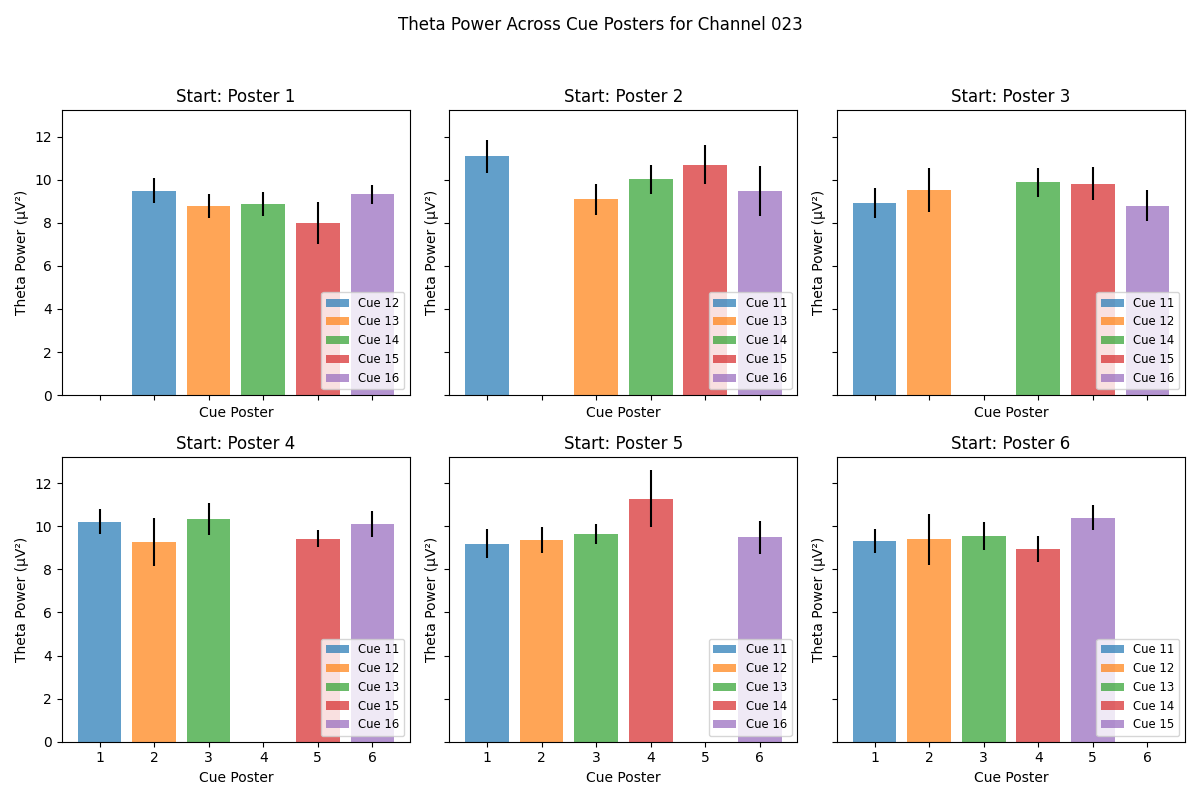

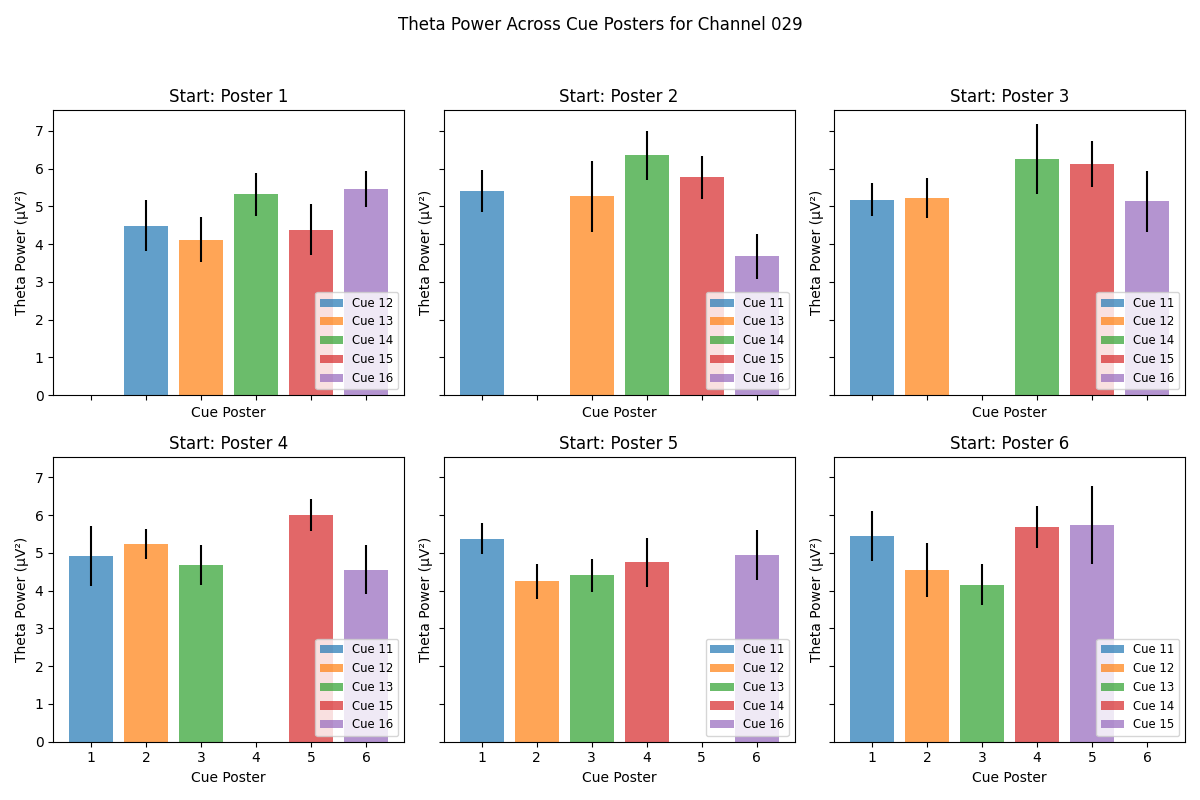

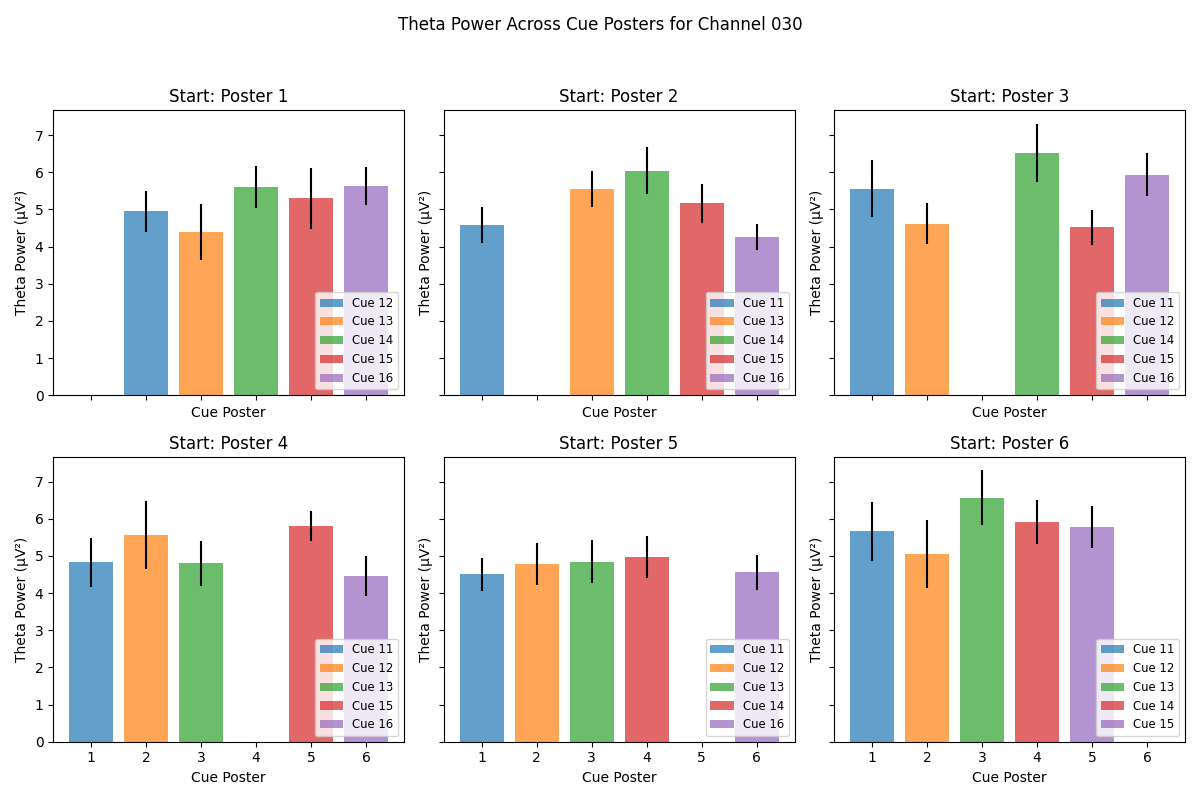

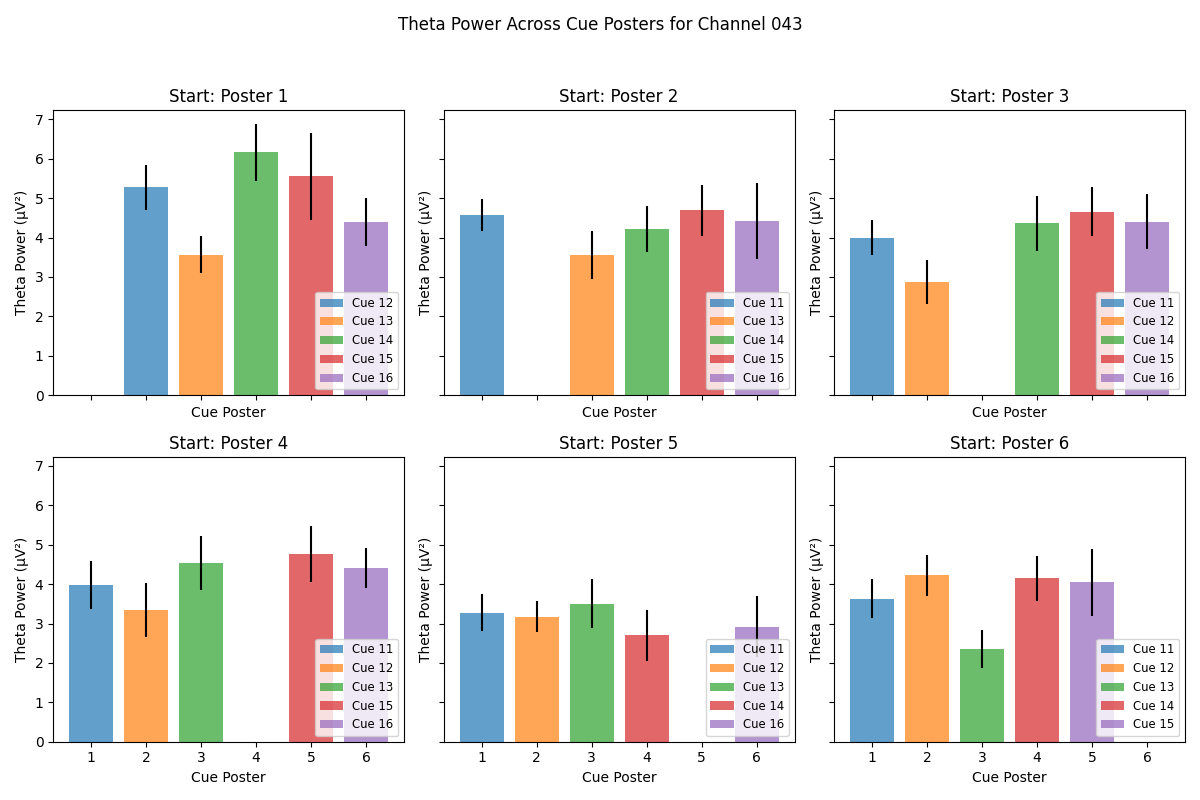

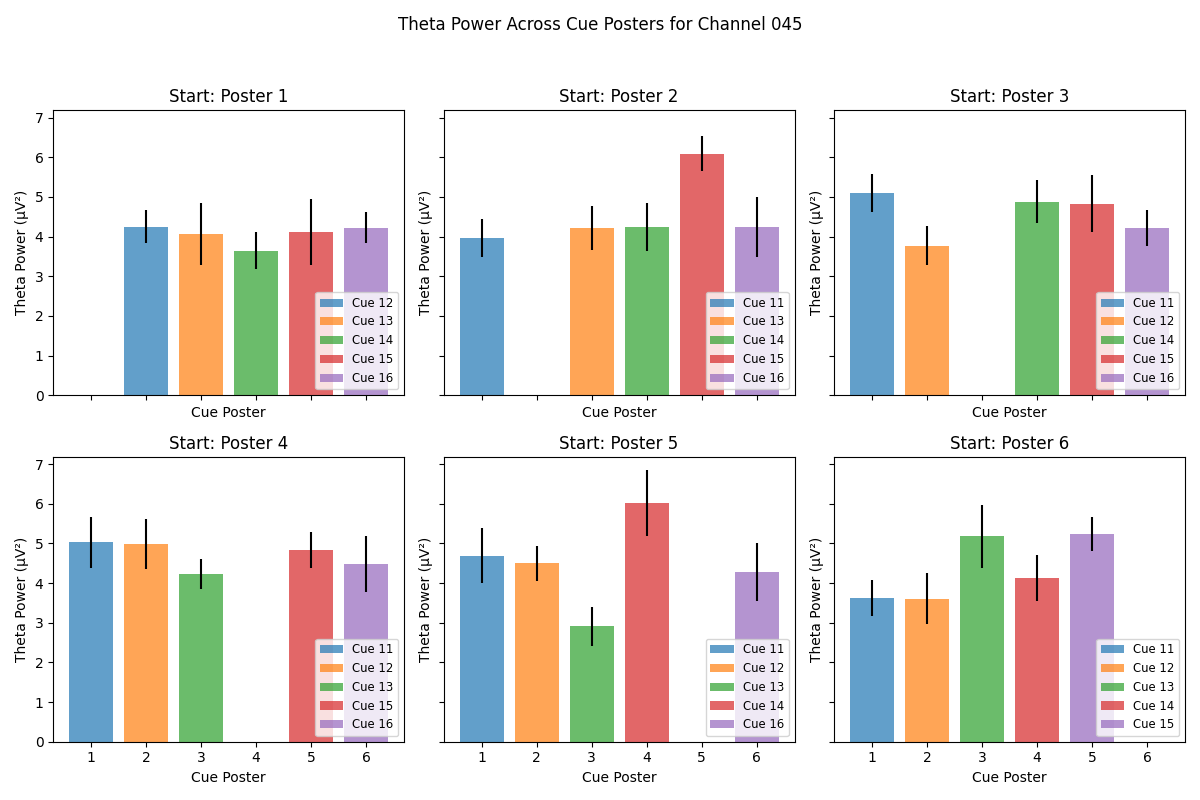

ANOVA results saved to anova_results_theta_power.csv
Post-hoc Tukey results saved to posthoc_results_theta_power.csv

Significant Post-Hoc Results: 
    channel  start_position  group1  group2  mean_diff   p_adj   lower   upper  \
1      019              32      11      14     2.3470  0.0282  0.1732  4.5209   
18     019              35      13      16     2.8347  0.0080  0.5449  5.1244   
27     045              35      13      14     3.1060  0.0140  0.4501  5.7618   

    reject  
1     True  
18    True  
27    True  


In [17]:
# Define theta range
theta_range = (3, 12)

# Data structures to store ANOVA and Post-Hoc results
anova_results = []
posthoc_results = []

for ch in channels_of_interest:
    # Plot setup for each channel
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
        ax = axes[i]
        theta_power_by_cue = {}  # Store theta power grouped by cue onset
        all_theta_powers = []
        all_cue_labels = []

        for j, cue_onset in enumerate(np.sort(segments_df['cue_onset'].unique())):
            # Filter DataFrame for current start position, channel, and cue onset
            filtered_df = segments_df.loc[
                (segments_df['start_position'] == start_position) &
                (segments_df['channel'] == ch) &
                (segments_df['cue_onset'] == cue_onset)
            ]

            # Ensure there is PSD data to process
            if filtered_df.empty:
                continue

            # Extract PSD and frequency data
            psd_list = filtered_df['flat_spec_og'].tolist()
            freq_list = filtered_df['freq'].iloc[0][:150]  # Assuming freq is consistent
            psd_array = np.array(psd_list)

            # Get indexes for the theta band
            theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
            theta_psd = psd_array[:, theta_indices]

            # Sum theta power within the theta band for each trial
            mean_psd = np.sum(theta_psd, axis=1)
            mean_theta_power = np.mean(mean_psd)  # Mean across all trials
            sem_theta_power = sem(mean_psd)  # SEM across all trials

            # Store theta power data for ANOVA
            theta_power_by_cue[cue_onset] = mean_psd
            all_theta_powers.extend(mean_psd)
            all_cue_labels.extend([cue_onset] * len(mean_psd))

            # Plot mean and SEM
            ax.bar(j + 1, mean_theta_power, yerr=sem_theta_power, label=f'Cue {cue_onset}', alpha=0.7)

        # Customize subplot
        ax.set_title(f'Start: Poster {start_position % 10}')
        ax.set_xlabel('Cue Poster')
        ax.set_ylabel('Theta Power (μV²)')
        ax.set_xticks(np.arange(1, len(np.unique(segments_df['cue_onset'])) + 1, 1))
        ax.legend(loc="lower right", fontsize='small')

        # Perform ANOVA if there are at least two cue groups
        if len(theta_power_by_cue) > 1:
            f_stat, p_value = f_oneway(*theta_power_by_cue.values())
            anova_results.append({
                'channel': ch,
                'start_position': start_position,
                'f_stat': f_stat,
                'p_value': p_value
            })

            # Perform post-hoc Tukey HSD if ANOVA is significant
            if p_value < 0.05:
                tukey_result = pairwise_tukeyhsd(endog=all_theta_powers,
                                                 groups=all_cue_labels,
                                                 alpha=0.05)

                # Store post-hoc results
                for res in tukey_result.summary().data[1:]:  # Skip header
                    posthoc_results.append({
                        'channel': ch,
                        'start_position': start_position,
                        'group1': res[0],
                        'group2': res[1],
                        'mean_diff': res[2],
                        'p_adj': res[3],
                        'lower': res[4],
                        'upper': res[5],
                        'reject': res[6]
                    })

    # Adjust layout and add main title
    plt.suptitle(f'Theta Power Across Cue Posters for Channel {ch}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Convert ANOVA results to DataFrame
anova_results_df = pd.DataFrame(anova_results)
posthoc_results_df = pd.DataFrame(posthoc_results)

# Save results to CSV files
anova_results_df.to_csv("anova_results_theta_power.csv", index=False)
posthoc_results_df.to_csv("posthoc_results_theta_power.csv", index=False)

print("ANOVA results saved to anova_results_theta_power.csv")
print("Post-hoc Tukey results saved to posthoc_results_theta_power.csv")

# Display significant post-hoc results
significant_posthoc = posthoc_results_df[posthoc_results_df['reject'] == True]
print("\nSignificant Post-Hoc Results: \n", significant_posthoc)


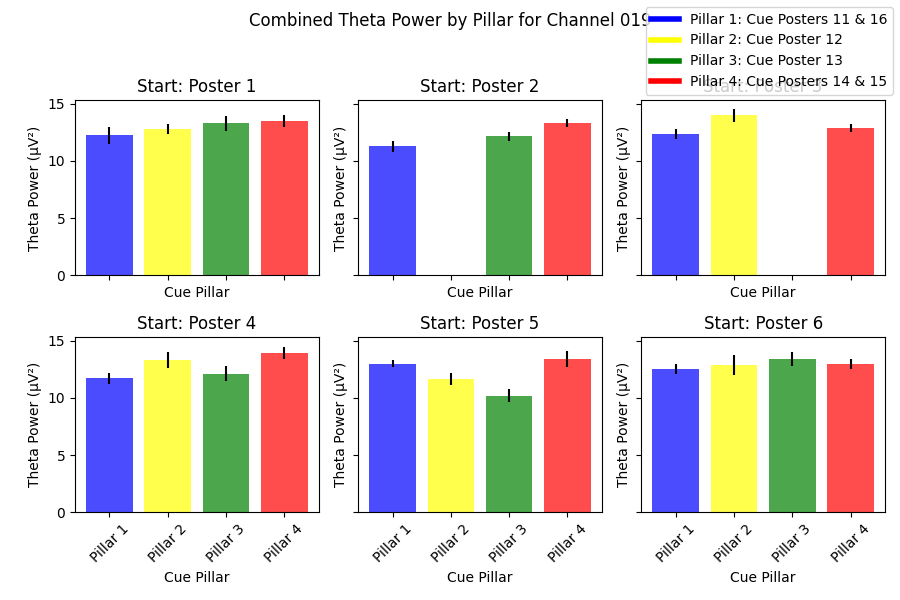

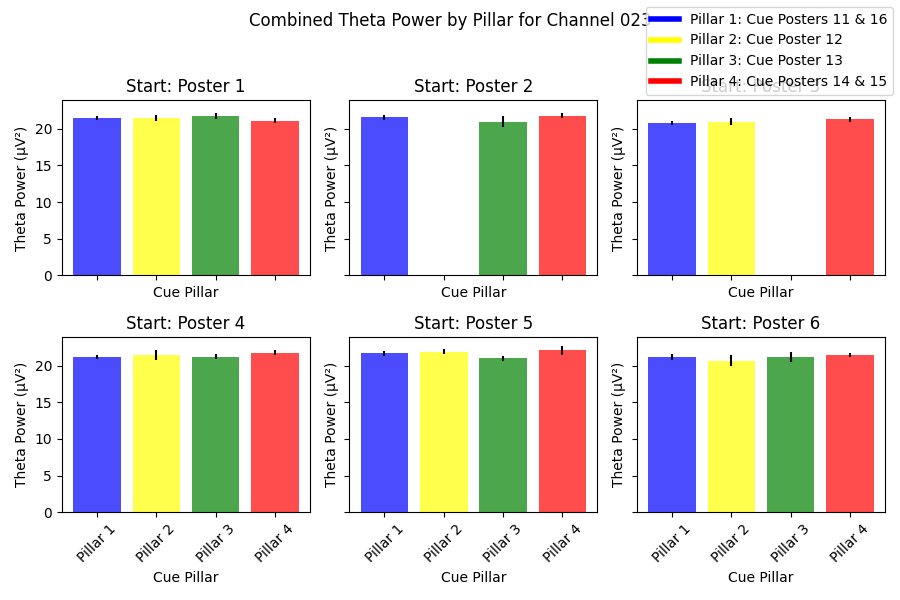

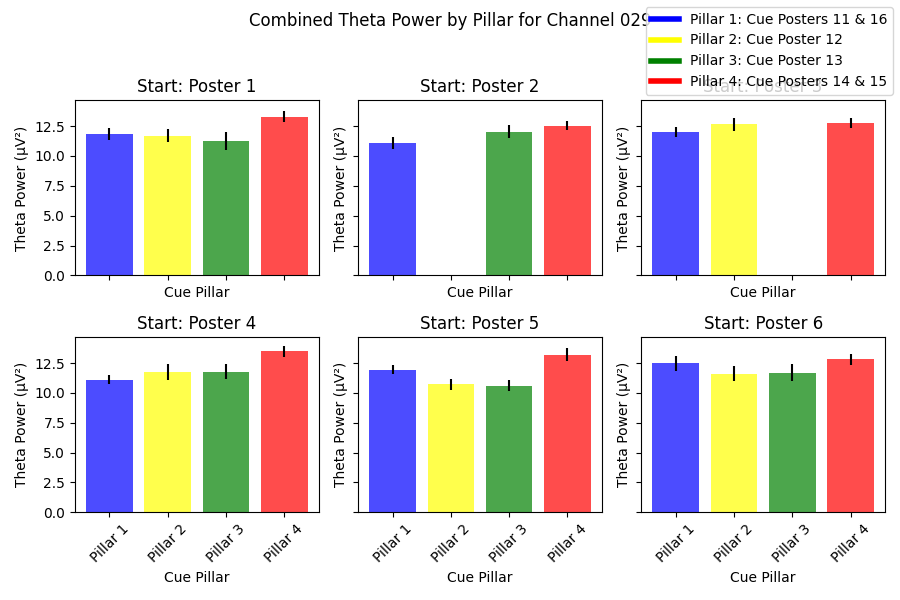

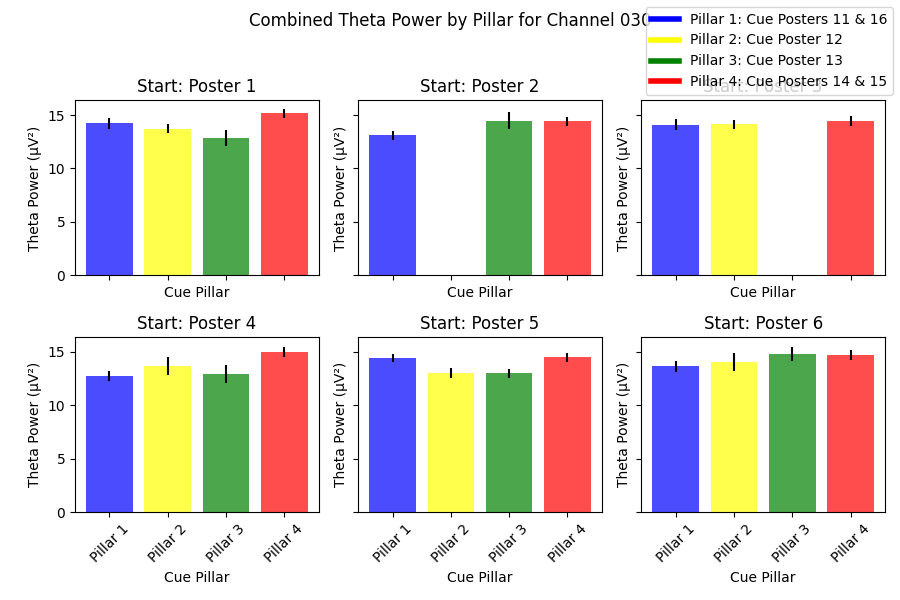

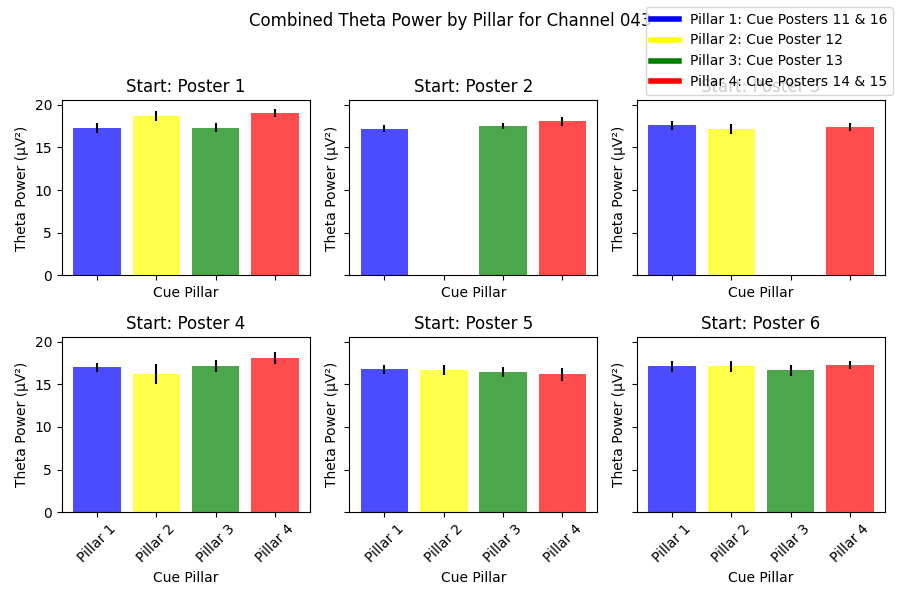

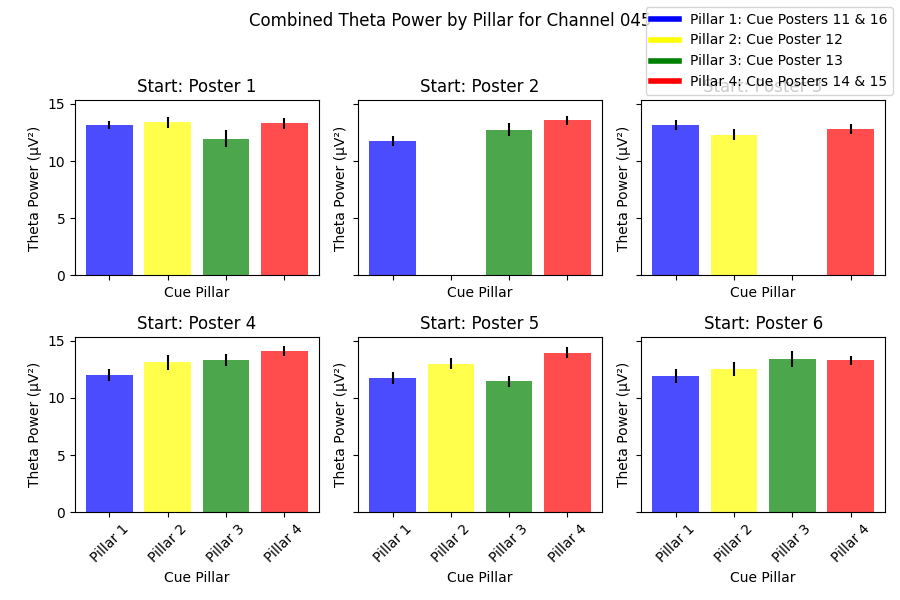

ANOVA results saved to anova_results_theta_power_by_pillar.csv
Post-hoc Tukey results saved to posthoc_tukey_results_theta_power_by_pillar.csv

Significant Post-Hoc Results:
    channel  start_position    group1    group2  mean_diff   p_adj   lower  \
1      019              32  Pillar 1  Pillar 4     2.0209  0.0026  0.6300   
5      019              34  Pillar 1  Pillar 4     2.1750  0.0146  0.3289   
10     019              35  Pillar 1  Pillar 3    -2.7884  0.0002 -4.4472   
14     019              35  Pillar 3  Pillar 4     3.2142  0.0022  0.9518   
22     029              32  Pillar 1  Pillar 4     1.4932  0.0399  0.0564   
26     029              34  Pillar 1  Pillar 4     2.3751  0.0017  0.7361   
34     029              35  Pillar 2  Pillar 4     2.4741  0.0135  0.3928   
35     029              35  Pillar 3  Pillar 4     2.6027  0.0069  0.5644   
41     030              31  Pillar 3  Pillar 4     2.3271  0.0151  0.3426   
44     030              34  Pillar 1  Pillar 4     2.26

In [18]:
# Define theta range
theta_range = (3, 12)

# Define pillar groups and corresponding colors
pillar_colors = [[11, 16], [12], [13], [14, 15]]
pillar_color_map = {
    0: 'blue',    # Pillar 1: Cue Posters 11 & 16
    1: 'yellow',  # Pillar 2: Cue Poster 12
    2: 'green',   # Pillar 3: Cue Poster 13
    3: 'red'      # Pillar 4: Cue Posters 14 & 15
}

anova_results = []
posthoc_results = []

for ch in channels_of_interest:
    fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
        ax = axes[i]
        theta_power_by_pillar = {}  # Store theta power for each pillar

        for pillar_idx, pillar_group in enumerate(pillar_colors):
            combined_theta_powers = []

            for cue_onset in pillar_group:
                filtered_df = segments_df.loc[
                    (segments_df['start_position'] == start_position) &
                    (segments_df['channel'] == ch) &
                    (segments_df['cue_onset'] == cue_onset)
                ]

                if filtered_df.empty:
                    continue

                # Extract PSD and frequency data
                psd_list = filtered_df['psd'].tolist()
                freq_list = filtered_df['freq'].iloc[0][:150]  # Assuming freq is consistent
                psd_array = np.array(psd_list)

                # Get indexes for the theta band
                theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
                theta_psd = psd_array[:, theta_indices]

                # Sum theta power within the theta band for each trial
                mean_psd = np.sum(theta_psd, axis=1)
                combined_theta_powers.extend(mean_psd)

            if combined_theta_powers:
                mean_theta_power = np.mean(combined_theta_powers)
                sem_theta_power = sem(combined_theta_powers)

                # Store data for ANOVA
                theta_power_by_pillar[f'Pillar {pillar_idx+1}'] = combined_theta_powers

                # Plot mean and SEM
                ax.bar(pillar_idx + 1, mean_theta_power, yerr=sem_theta_power,
                       color=pillar_color_map[pillar_idx], alpha=0.7)

        # Run ANOVA if we have theta power data from at least two pillars
        if len(theta_power_by_pillar) > 1:
            f_stat, p_value = f_oneway(*theta_power_by_pillar.values())
            anova_results.append({
                'channel': ch,
                'start_position': start_position,
                'f_stat': f_stat,
                'p_value': p_value
            })

            # Perform Tukey HSD post-hoc if ANOVA is significant
            if p_value < 0.05:
                all_theta_powers = []
                all_pillar_labels = []

                for pillar, values in theta_power_by_pillar.items():
                    all_theta_powers.extend(values)
                    all_pillar_labels.extend([pillar] * len(values))

                tukey_result = pairwise_tukeyhsd(endog=all_theta_powers,
                                                 groups=all_pillar_labels,
                                                 alpha=0.05)

                # Store post-hoc results
                for res in tukey_result.summary().data[1:]:  # Skip header
                    posthoc_results.append({
                        'channel': ch,
                        'start_position': start_position,
                        'group1': res[0],
                        'group2': res[1],
                        'mean_diff': res[2],
                        'p_adj': res[3],
                        'lower': res[4],
                        'upper': res[5],
                        'reject': res[6]
                    })

        # Customize subplot
        ax.set_title(f'Start: Poster {start_position % 10}')
        ax.set_xlabel('Cue Pillar')
        ax.set_ylabel('Theta Power (μV²)')
        ax.set_xticks([1, 2, 3, 4])
        ax.set_xticklabels([f'Pillar {idx+1}' for idx in range(len(pillar_colors))], rotation=45)

    # Create a custom legend
    custom_legend = [
        plt.Line2D([0], [0], color='blue', lw=4, label='Pillar 1: Cue Posters 11 & 16'),
        plt.Line2D([0], [0], color='yellow', lw=4, label='Pillar 2: Cue Poster 12'),
        plt.Line2D([0], [0], color='green', lw=4, label='Pillar 3: Cue Poster 13'),
        plt.Line2D([0], [0], color='red', lw=4, label='Pillar 4: Cue Posters 14 & 15')
    ]
    fig.legend(handles=custom_legend, loc='upper right', fontsize='medium')

    plt.suptitle(f'Combined Theta Power by Pillar for Channel {ch}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Save ANOVA and post-hoc results
anova_results_df = pd.DataFrame(anova_results)
posthoc_results_df = pd.DataFrame(posthoc_results)

anova_results_df.to_csv("anova_results_theta_power_by_pillar.csv", index=False)
posthoc_results_df.to_csv("posthoc_tukey_results_theta_power_by_pillar.csv", index=False)

print("ANOVA results saved to anova_results_theta_power_by_pillar.csv")
print("Post-hoc Tukey results saved to posthoc_tukey_results_theta_power_by_pillar.csv")

# Display significant post-hoc results
significant_posthoc = posthoc_results_df[posthoc_results_df['reject'] == True]
print("\nSignificant Post-Hoc Results:\n", significant_posthoc)


In [ ]:
# Define theta range
theta_range = (2, 12)

# Data structures to store ANOVA and Post-Hoc results by starting position
anova_start_pos_results = []
posthoc_start_pos_results = []

for ch in channels_of_interest:
    fig, ax = plt.subplots(figsize=(4, 3))

    theta_power_by_start_pos = {}  # Store theta power for each starting position

    for start_position in np.sort(segments_df['start_position'].unique()):
        combined_theta_powers = []

        # Aggregate theta power for all cue onsets from this starting position
        filtered_df = segments_df.loc[
            (segments_df['start_position'] == start_position) &
            (segments_df['channel'] == ch)
        ]

        if filtered_df.empty:
            continue

        # Extract PSD and frequency data
        psd_list = filtered_df['psd'].tolist()
        freq_list = filtered_df['freq'].iloc[0][:150]  # Assuming freq is consistent
        psd_array = np.array(psd_list)

        # Get indexes for the theta band
        theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
        theta_psd = psd_array[:, theta_indices]

        # Sum theta power within the theta band for each trial
        mean_psd = np.sum(theta_psd, axis=1)
        combined_theta_powers.extend(mean_psd)

        if combined_theta_powers:
            mean_theta_power = np.mean(combined_theta_powers)
            sem_theta_power = sem(combined_theta_powers)

            # Store data for ANOVA
            theta_power_by_start_pos[f'Start {start_position}'] = combined_theta_powers

            # Plot mean and SEM
            ax.bar(start_position, mean_theta_power, yerr=sem_theta_power, alpha=0.7, label=f'Start {start_position}')

    # Run ANOVA if we have theta power data from at least two starting positions
    if len(theta_power_by_start_pos) > 1:
        f_stat, p_value = f_oneway(*theta_power_by_start_pos.values())
        anova_start_pos_results.append({
            'channel': ch,
            'f_stat': f_stat,
            'p_value': p_value
        })

        # Perform Tukey HSD post-hoc if ANOVA is significant
        if p_value < 0.05:
            all_theta_powers = []
            all_start_pos_labels = []

            for start_pos, values in theta_power_by_start_pos.items():
                all_theta_powers.extend(values)
                all_start_pos_labels.extend([start_pos] * len(values))

            tukey_result = pairwise_tukeyhsd(endog=all_theta_powers,
                                             groups=all_start_pos_labels,
                                             alpha=0.05)

            # Store post-hoc results
            for res in tukey_result.summary().data[1:]:  # Skip header
                posthoc_start_pos_results.append({
                    'channel': ch,
                    'group1': res[0],
                    'group2': res[1],
                    'mean_diff': res[2],
                    'p_adj': res[3],
                    'lower': res[4],
                    'upper': res[5],
                    'reject': res[6]
                })

    # Customize plot
    ax.set_title(f'Theta Power by Starting Position for Ch {ch}')
    ax.set_xlabel('Starting Position')
    ax.set_ylabel('Theta Power (μV²)')
    ax.legend(loc='lower right', fontsize='small')

    plt.tight_layout()
    plt.show()

# Save ANOVA and post-hoc results for starting positions
anova_start_pos_df = pd.DataFrame(anova_start_pos_results)
posthoc_start_pos_df = pd.DataFrame(posthoc_start_pos_results)

anova_start_pos_df.to_csv("anova_results_theta_power_by_starting_position.csv", index=False)
posthoc_start_pos_df.to_csv("posthoc_tukey_results_theta_power_by_starting_position.csv", index=False)

print("ANOVA results saved to anova_results_theta_power_by_starting_position.csv")
print("Post-hoc Tukey results saved to posthoc_tukey_results_theta_power_by_starting_position.csv")

# Display significant post-hoc results
significant_posthoc_start_pos = posthoc_start_pos_df[posthoc_start_pos_df['reject'] == True]
print("\nSignificant Post-Hoc Results (Starting Positions):\n", significant_posthoc_start_pos)


In [26]:
north = { 
    31: [12,14,15,16],
    32: [],
    33: [14,15],
    34: [],
    35: [14,],
    36: [12,14]
    }

south = { 
    31: [],
    32: [11,16],
    33: [],
    34: [11,13,15,16],
    35: [11,13],
    36: [11,]
    }

east = { 
    31: [13,],
    32: [13,14,15],
    33: [],
    34: [],
    35: [],
    36: [13,15]
    }

west = { 
    31: [],
    32: [],
    33: [11,12,16],
    34: [12,],
    35: [12,16],
    36: []
    }

# front = { 
#     31: [12,14,15,16],
#     32: [13,14,15],
#     33: [11,12,16],
#     34: [11,13,15,16],
#     35: [14,],
#     36: [11,]
#     }

# behind = { 
#     31: [],
#     32: [],
#     33: [],
#     34: [],
#     35: [11,13,16],
#     36: [12,14,15]
#     }


front = { 
    31: [],
    32: [],
    33: [],
    34: [],
    35: [14,],
    36: [11,]
    }

behind = { 
    31: [],
    32: [],
    33: [],
    34: [],
    35: [13],
    36: [12]
    }

go_left = {
   31: [12,],
   32: [14,],
   33: [11,],
   34: [13,],
   35: [11,12,16],
   36: [13,14,15]
   }
go_right = {
   31: [13,14,15,16],
   32: [13,15,11,16],
   33: [12,14,15,16],
   34: [12,15,16],
   35: [13,14],
   36: [12,]
   }

left = { 
    31: [12,],
    32: [14,],
    33: [11,],
    34: [13,],
    35: [11,12,16],
    36: [13,14,15]
    }

right = { 
    31: [13,14,15],
    32: [11,13,16],
    33: [12,14,15],
    34: [12,16],
    35: [13,],
    36: [12,]
    }

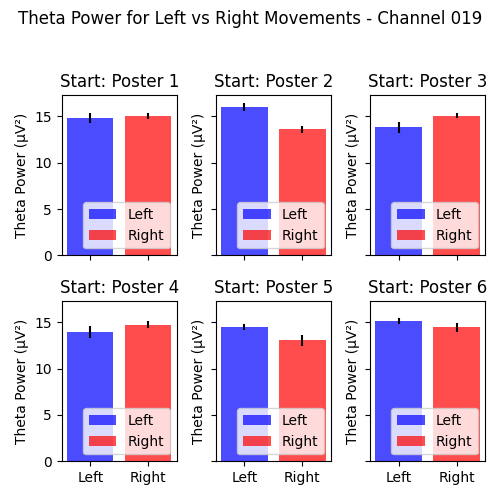

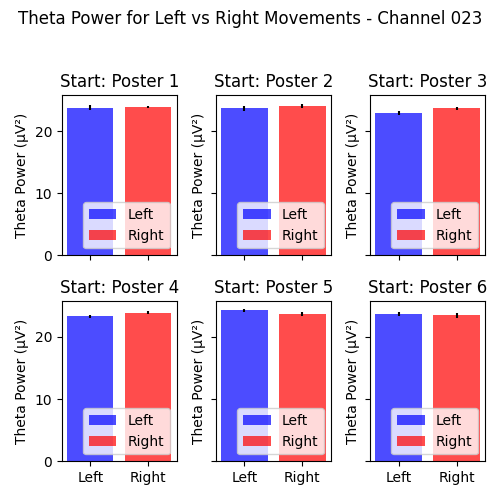

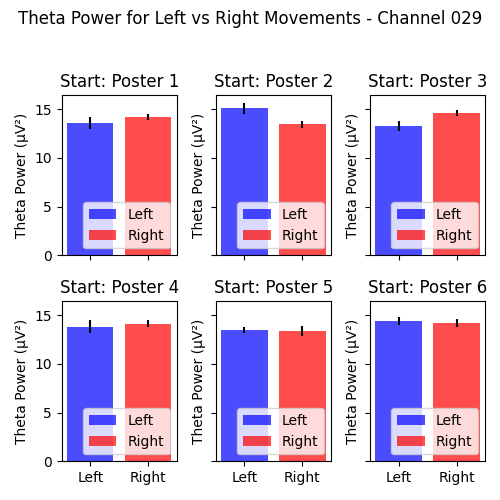

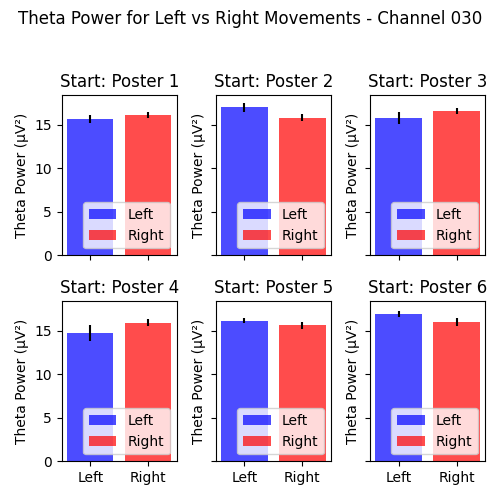

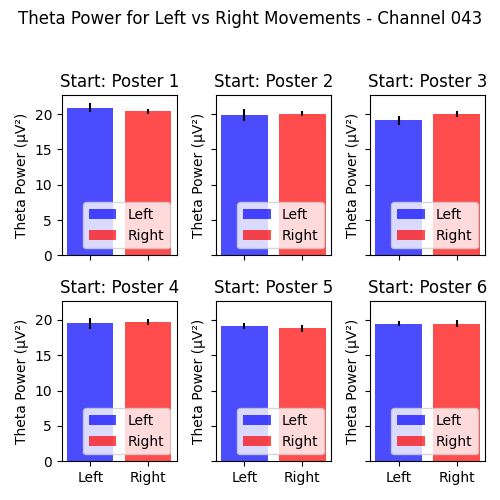

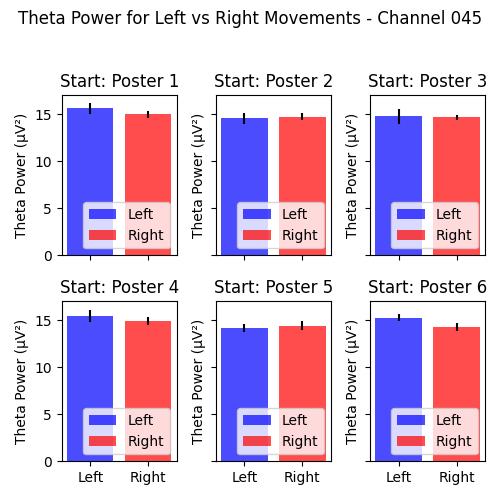

T-test results saved to ttest_results_theta_power_left_right.csv

Significant Differences in Theta Power (T-test): 
    channel  start_position    t_stat   p_ttest
1      019              32  4.297986  0.000146
4      019              35  2.098416  0.042341
13     029              32  2.568361  0.017316
14     029              33 -2.163274  0.040071


In [22]:
from scipy.stats import ttest_ind, sem

# Define theta range
theta_range = (3, 12)

# Data structure to store statistical test results
ttest_results = []

# Iterate through channels of interest
for ch in channels_of_interest:
    fig, axes = plt.subplots(2, 3, figsize=(5, 5), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
        ax = axes[i]

        left_theta_powers = []
        right_theta_powers = []

        for j, cue_onset in enumerate(np.sort(segments_df['cue_onset'].unique())):
            prev_reward = start_position  # Since start_position corresponds to the previous reward

            # Determine if this cue_onset belongs to left or right movement
            if prev_reward in go_left and cue_onset in go_left[prev_reward]:
                move_direction = "left"
            elif prev_reward in go_right and cue_onset in go_right[prev_reward]:
                move_direction = "right"
            else:
                continue  # Ignore if it's neither left nor right

            # Filter DataFrame for current start position, channel, and cue onset
            filtered_df = segments_df.loc[
                (segments_df['start_position'] == start_position) &
                (segments_df['channel'] == ch) &
                (segments_df['cue_onset'] == cue_onset)
            ]

            if filtered_df.empty:
                continue

            # Extract PSD and frequency data
            psd_list = filtered_df['psd'].tolist()
            freq_list = filtered_df['freq'].iloc[0][:150]  # Assuming freq is consistent
            psd_array = np.array(psd_list)

            # Get indexes for the theta band
            theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
            theta_psd = psd_array[:, theta_indices]

            # Sum theta power within the theta band for each trial
            mean_psd = np.sum(theta_psd, axis=1)

            # Store in corresponding movement direction
            if move_direction == "left":
                left_theta_powers.extend(mean_psd)
            else:
                right_theta_powers.extend(mean_psd)

        # Compute mean and SEM
        mean_left = np.mean(left_theta_powers) if left_theta_powers else np.nan
        sem_left = sem(left_theta_powers) if left_theta_powers else np.nan
        mean_right = np.mean(right_theta_powers) if right_theta_powers else np.nan
        sem_right = sem(right_theta_powers) if right_theta_powers else np.nan

        # Plot bar graph for left vs right movements
        ax.bar(1, mean_left, yerr=sem_left, label="Left", alpha=0.7, color="blue")
        ax.bar(2, mean_right, yerr=sem_right, label="Right", alpha=0.7, color="red")

        ax.set_title(f'Start: Poster {start_position % 10}')
        ax.set_xticks([1, 2])
        ax.set_xticklabels(["Left", "Right"])
        ax.set_ylabel('Theta Power (μV²)')
        ax.legend(loc='lower right')

        # Perform t-test if both groups have data
        if len(left_theta_powers) > 1 and len(right_theta_powers) > 1:
            t_stat, p_ttest = ttest_ind(left_theta_powers, right_theta_powers, equal_var=False)  # Welch’s t-test
            
            # Store results
            ttest_results.append({
                'channel': ch,
                'start_position': start_position,
                't_stat': t_stat,
                'p_ttest': p_ttest
            })

    plt.suptitle(f'Theta Power for Left vs Right Movements - Channel {ch}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Convert test results to DataFrame
ttest_results_df = pd.DataFrame(ttest_results)

# Save results to CSV files
ttest_results_df.to_csv("ttest_results_theta_power_left_right.csv", index=False)

print("T-test results saved to ttest_results_theta_power_left_right.csv")

# Display significant results
significant_results = ttest_results_df[ttest_results_df['p_ttest'] < 0.05]
print("\nSignificant Differences in Theta Power (T-test): \n", significant_results)


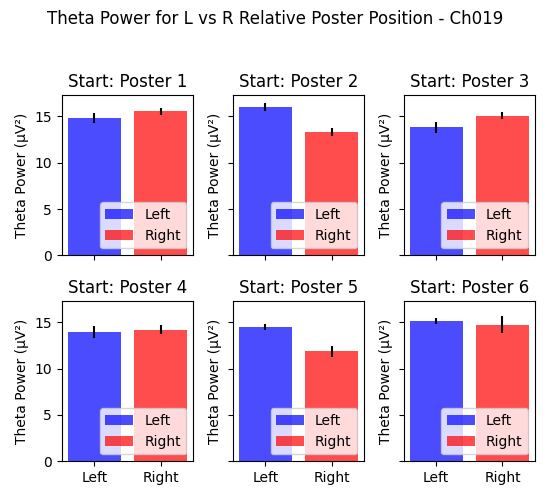

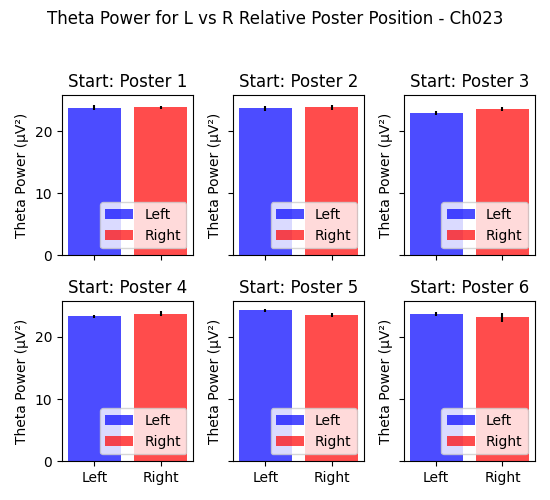

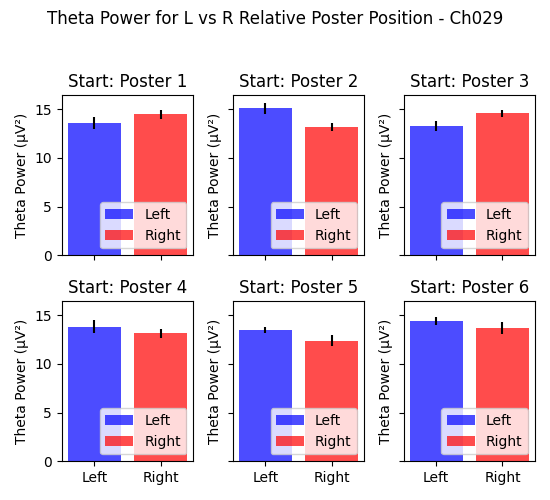

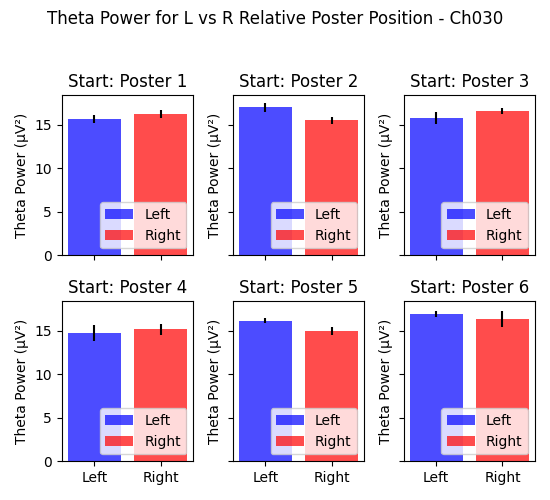

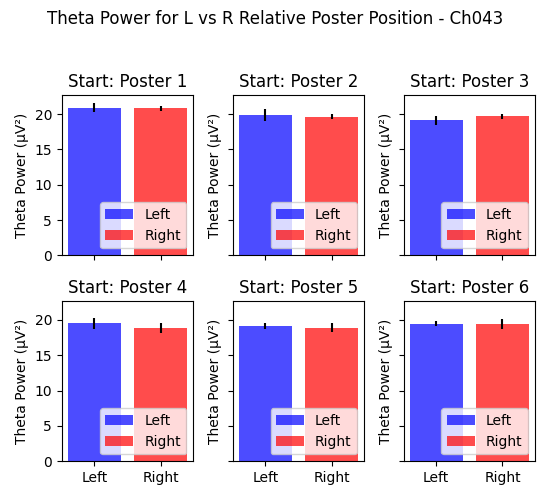

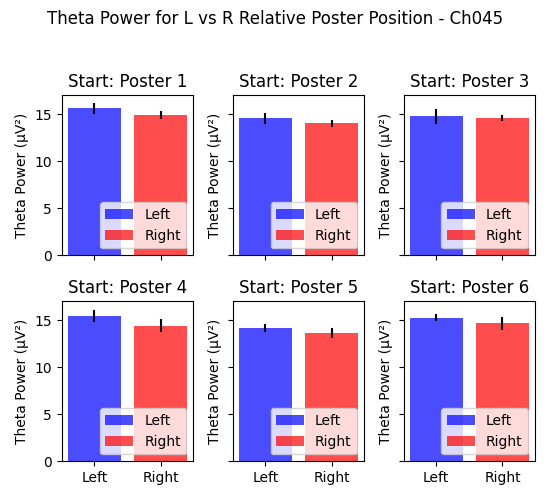

T-test results saved to ttest_results_theta_power_left_right_relative_position.csv

Significant Differences in Theta Power (T-test): 
    channel  start_position    t_stat   p_ttest
1      019              32  4.527218  0.000062
4      019              35  3.781872  0.000827
13     029              32  2.811961  0.009026
19     030              32  2.303023  0.028227


In [25]:
from scipy.stats import ttest_ind, sem

# Define theta range
theta_range = (2, 12)

# Data structure to store statistical test results
ttest_results = []

# Iterate through channels of interest
for ch in channels_of_interest:
    fig, axes = plt.subplots(2, 3, figsize=(5.5, 5), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
        ax = axes[i]

        left_theta_powers = []
        right_theta_powers = []

        for j, cue_onset in enumerate(np.sort(segments_df['cue_onset'].unique())):
            prev_reward = start_position  # Since start_position corresponds to the previous reward

            # Determine if this cue_onset belongs to left or right movement
            if prev_reward in left and cue_onset in left[prev_reward]:
                move_direction = "left"
            elif prev_reward in right and cue_onset in right[prev_reward]:
                move_direction = "right"
            else:
                continue  # Ignore if it's neither left nor right

            # Filter DataFrame for current start position, channel, and cue onset
            filtered_df = segments_df.loc[
                (segments_df['start_position'] == start_position) &
                (segments_df['channel'] == ch) &
                (segments_df['cue_onset'] == cue_onset)
            ]

            if filtered_df.empty:
                continue

            # Extract PSD and frequency data
            psd_list = filtered_df['psd'].tolist()
            freq_list = filtered_df['freq'].iloc[0][:150]  # Assuming freq is consistent
            psd_array = np.array(psd_list)

            # Get indexes for the theta band
            theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
            theta_psd = psd_array[:, theta_indices]

            # Sum theta power within the theta band for each trial
            mean_psd = np.sum(theta_psd, axis=1)

            # Store in corresponding movement direction
            if move_direction == "left":
                left_theta_powers.extend(mean_psd)
            else:
                right_theta_powers.extend(mean_psd)

        # Compute mean and SEM
        mean_left = np.mean(left_theta_powers) if left_theta_powers else np.nan
        sem_left = sem(left_theta_powers) if left_theta_powers else np.nan
        mean_right = np.mean(right_theta_powers) if right_theta_powers else np.nan
        sem_right = sem(right_theta_powers) if right_theta_powers else np.nan

        # Plot bar graph for left vs right movements
        ax.bar(1, mean_left, yerr=sem_left, label="Left", alpha=0.7, color="blue")
        ax.bar(2, mean_right, yerr=sem_right, label="Right", alpha=0.7, color="red")

        ax.set_title(f'Start: Poster {start_position % 10}')
        ax.set_xticks([1, 2])
        ax.set_xticklabels(["Left", "Right"])
        ax.set_ylabel('Theta Power (μV²)')
        ax.legend(loc='lower right')

        # Perform t-test if both groups have data
        if len(left_theta_powers) > 1 and len(right_theta_powers) > 1:
            t_stat, p_ttest = ttest_ind(left_theta_powers, right_theta_powers, equal_var=False)  # Welch’s t-test
            
            # Store results
            ttest_results.append({
                'channel': ch,
                'start_position': start_position,
                't_stat': t_stat,
                'p_ttest': p_ttest
            })

    plt.suptitle(f'Theta Power for L vs R Relative Poster Position - Ch{ch}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Convert test results to DataFrame
ttest_results_df = pd.DataFrame(ttest_results)

# Save results to CSV files
ttest_results_df.to_csv("ttest_results_theta_power_left_right_relative_position.csv", index=False)

print("T-test results saved to ttest_results_theta_power_left_right_relative_position.csv")

# Display significant results
significant_results = ttest_results_df[ttest_results_df['p_ttest'] < 0.05]
print("\nSignificant Differences in Theta Power (T-test): \n", significant_results)


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


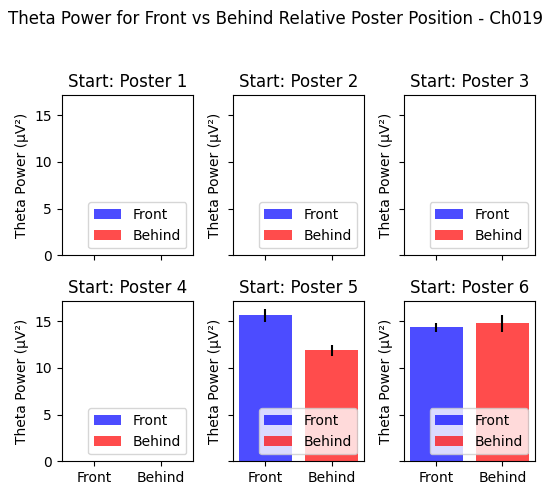

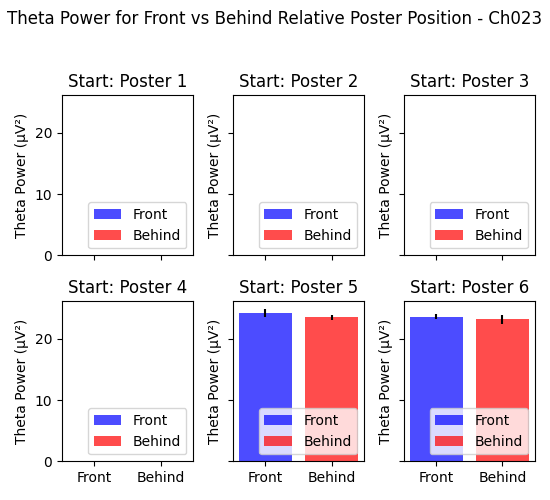

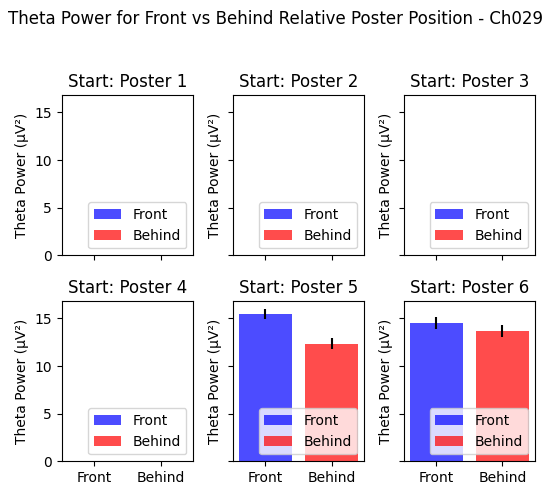

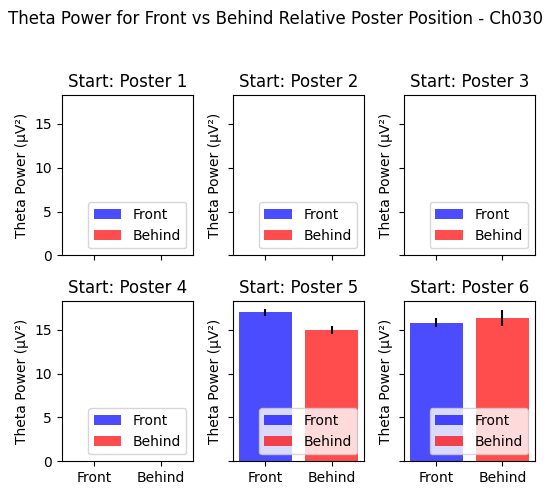

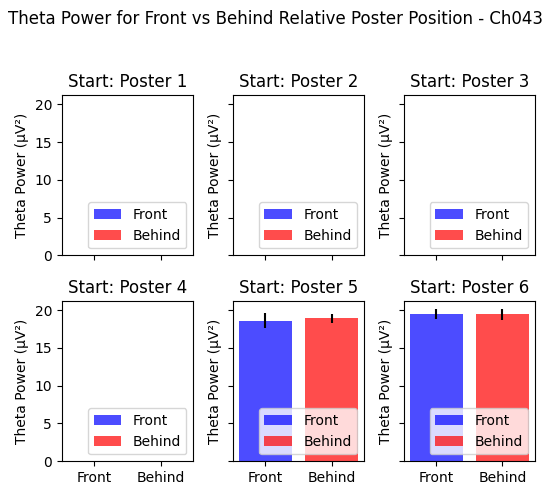

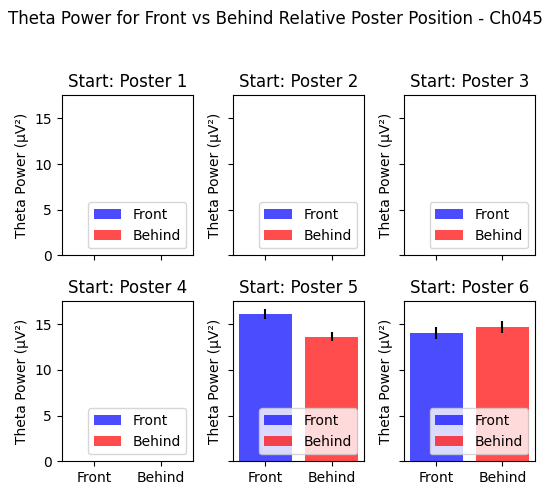

T-test results saved to ttest_results_theta_power_front_behind_relative_position.csv

Significant Differences in Theta Power (T-test): 
    channel  start_position    t_stat   p_ttest
0      019              35  4.104788  0.000703
4      029              35  3.920748  0.000845
6      030              35  3.098143  0.005312
10     045              35  3.379813  0.003288


In [27]:
# Define theta range
theta_range = (2, 12)

# Data structure to store statistical test results
ttest_results = []

# Iterate through channels of interest
for ch in channels_of_interest:
    fig, axes = plt.subplots(2, 3, figsize=(5.5, 5), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
        ax = axes[i]

        front_theta_powers = []
        behind_theta_powers = []

        for j, cue_onset in enumerate(np.sort(segments_df['cue_onset'].unique())):
            prev_reward = start_position  # Since start_position corresponds to the previous reward

            # Determine if this cue_onset belongs to front or behind
            if prev_reward in front and cue_onset in front[prev_reward]:
                move_direction = "front"
            elif prev_reward in behind and cue_onset in behind[prev_reward]:
                move_direction = "behind"
            else:
                continue  # Ignore if it's neither front nor behind

            # Filter DataFrame for current start position, channel, and cue onset
            filtered_df = segments_df.loc[
                (segments_df['start_position'] == start_position) &
                (segments_df['channel'] == ch) &
                (segments_df['cue_onset'] == cue_onset)
            ]

            if filtered_df.empty:
                continue

            # Extract PSD and frequency data
            psd_list = filtered_df['psd'].tolist()
            freq_list = filtered_df['freq'].iloc[0][:150]  # Assuming freq is consistent
            psd_array = np.array(psd_list)

            # Get indexes for the theta band
            theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
            theta_psd = psd_array[:, theta_indices]

            # Sum theta power within the theta band for each trial
            mean_psd = np.sum(theta_psd, axis=1)

            # Store in corresponding movement direction
            if move_direction == "front":
                front_theta_powers.extend(mean_psd)
            else:
                behind_theta_powers.extend(mean_psd)

        # Compute mean and SEM
        mean_front = np.mean(front_theta_powers) if front_theta_powers else np.nan
        sem_front = sem(front_theta_powers) if front_theta_powers else np.nan
        mean_behind = np.mean(behind_theta_powers) if behind_theta_powers else np.nan
        sem_behind = sem(behind_theta_powers) if behind_theta_powers else np.nan

        # Plot bar graph for front vs behind
        ax.bar(1, mean_front, yerr=sem_front, label="Front", alpha=0.7, color="blue")
        ax.bar(2, mean_behind, yerr=sem_behind, label="Behind", alpha=0.7, color="red")

        ax.set_title(f'Start: Poster {start_position % 10}')
        ax.set_xticks([1, 2])
        ax.set_xticklabels(["Front", "Behind"])
        ax.set_ylabel('Theta Power (μV²)')
        ax.legend(loc='lower right')

        # Perform t-test if both groups have data
        if len(front_theta_powers) > 1 and len(behind_theta_powers) > 1:
            t_stat, p_ttest = ttest_ind(front_theta_powers, behind_theta_powers, equal_var=False)  # Welch’s t-test
            
            # Store results
            ttest_results.append({
                'channel': ch,
                'start_position': start_position,
                't_stat': t_stat,
                'p_ttest': p_ttest
            })

    plt.suptitle(f'Theta Power for Front vs Behind Relative Poster Position - Ch{ch}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Convert test results to DataFrame
ttest_results_df = pd.DataFrame(ttest_results)

# Save results to CSV files
ttest_results_df.to_csv("ttest_results_theta_power_front_behind_relative_position.csv", index=False)

print("T-test results saved to ttest_results_theta_power_front_behind_relative_position.csv")

# Display significant results
significant_results = ttest_results_df[ttest_results_df['p_ttest'] < 0.05]
print("\nSignificant Differences in Theta Power (T-test): \n", significant_results)


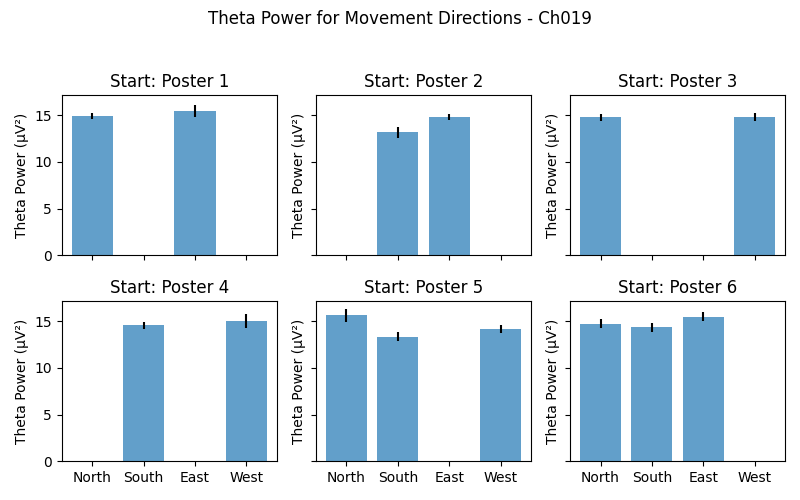

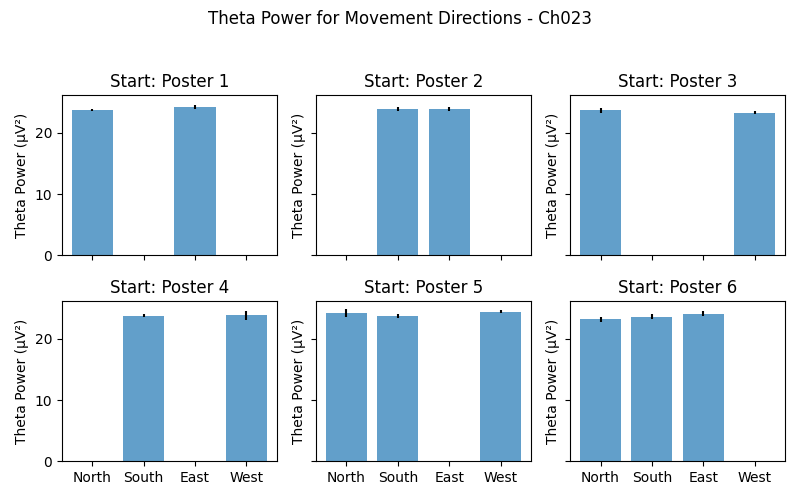

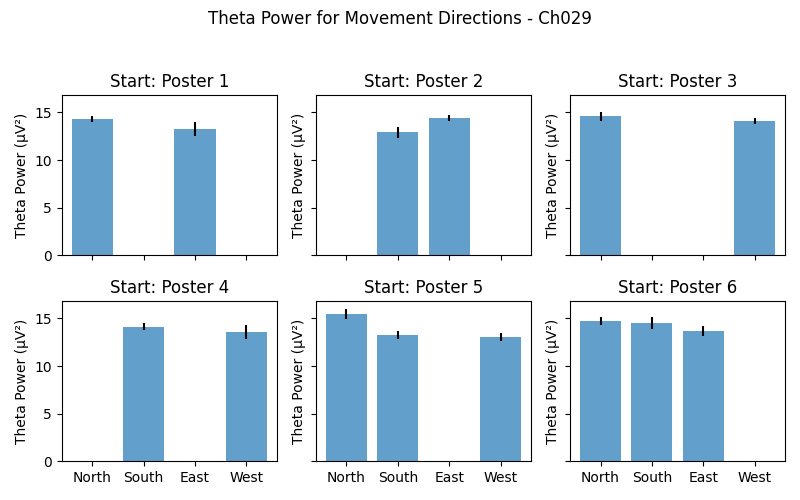

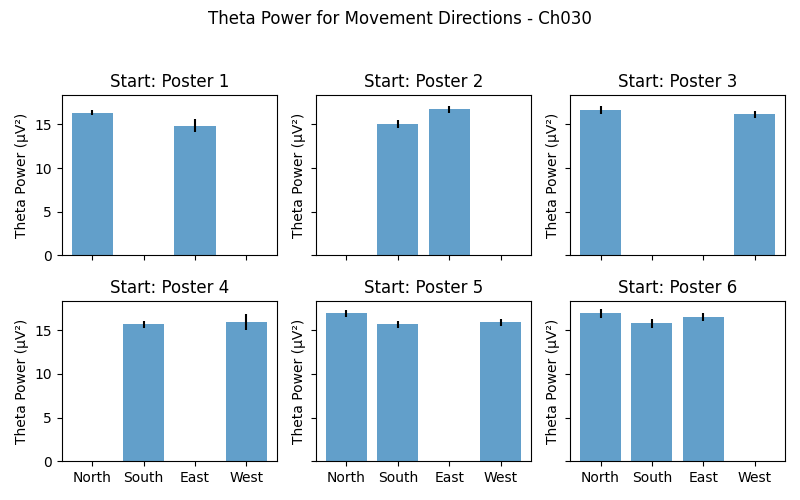

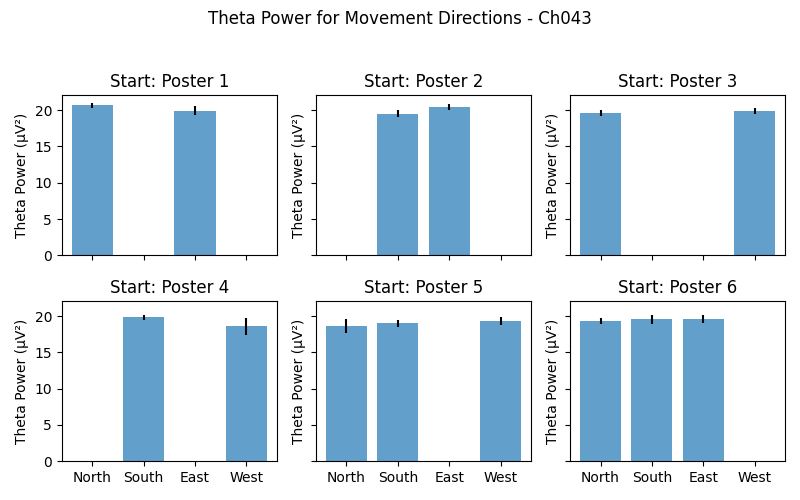

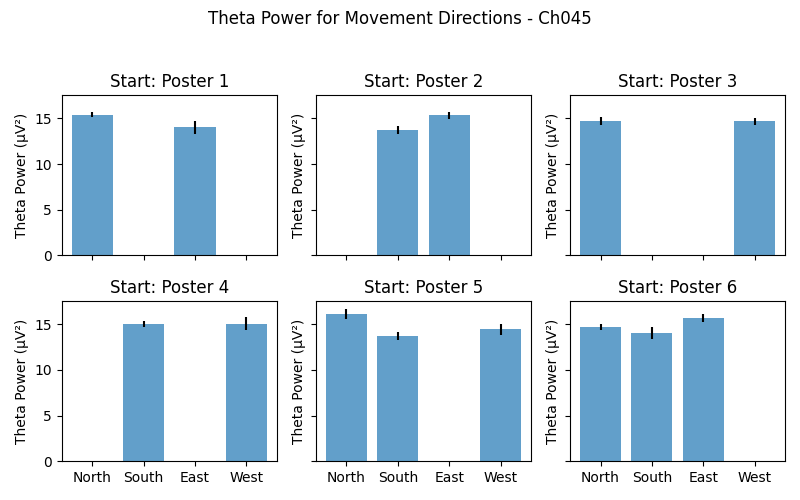

ANOVA results saved to anova_results_theta_power_directions.csv
Post-hoc Tukey results saved to posthoc_results_theta_power_directions.csv

Significant Post-Hoc Results: 
   channel  start_position group1 group2  mean_diff   p_adj   lower   upper  \
0     019              32   East  South    -1.6638  0.0096 -2.9068 -0.4207   
1     029              32   East  South    -1.5042  0.0105 -2.6426 -0.3657   
2     029              35  North  South    -2.2096  0.0334 -4.2757 -0.1436   
3     029              35  North   West    -2.4265  0.0201 -4.5329 -0.3201   
5     030              31   East  North     1.4526  0.0467  0.0218  2.8833   
6     030              32   East  South    -1.6513  0.0075 -2.8446 -0.4579   
7     045              31   East  North     1.4096  0.0456  0.0281  2.7910   
8     045              32   East  South    -1.6118  0.0083 -2.7922 -0.4315   
9     045              35  North  South    -2.4297  0.0346 -4.7140 -0.1454   

   reject  
0    True  
1    True  
2    True  

In [28]:
# Define theta range
theta_range = (2, 12)

# Data structure to store ANOVA and Post-Hoc test results
anova_results = []
posthoc_results = []

# Iterate through channels of interest
for ch in channels_of_interest:
    fig, axes = plt.subplots(2, 3, figsize=(8, 5), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
        ax = axes[i]

        theta_power_by_direction = {'North': [], 'South': [], 'East': [], 'West': []}
        all_theta_powers = []
        all_direction_labels = []

        for j, cue_onset in enumerate(np.sort(segments_df['cue_onset'].unique())):
            prev_reward = start_position  # Since start_position corresponds to the previous reward

            # Determine movement direction
            if prev_reward in north and cue_onset in north[prev_reward]:
                move_direction = "North"
            elif prev_reward in south and cue_onset in south[prev_reward]:
                move_direction = "South"
            elif prev_reward in east and cue_onset in east[prev_reward]:
                move_direction = "East"
            elif prev_reward in west and cue_onset in west[prev_reward]:
                move_direction = "West"
            else:
                continue  # Ignore if it's not in any direction

            # Filter DataFrame for current start position, channel, and cue onset
            filtered_df = segments_df.loc[
                (segments_df['start_position'] == start_position) &
                (segments_df['channel'] == ch) &
                (segments_df['cue_onset'] == cue_onset)
            ]

            if filtered_df.empty:
                continue

            # Extract PSD and frequency data
            psd_list = filtered_df['psd'].tolist()
            freq_list = filtered_df['freq'].iloc[0][:150]  # Assuming freq is consistent
            psd_array = np.array(psd_list)

            # Get indexes for the theta band
            theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
            theta_psd = psd_array[:, theta_indices]

            # Sum theta power within the theta band for each trial
            mean_psd = np.sum(theta_psd, axis=1)
            theta_power_by_direction[move_direction].extend(mean_psd)
            all_theta_powers.extend(mean_psd)
            all_direction_labels.extend([move_direction] * len(mean_psd))

        # Compute mean and SEM for each direction
        mean_values = {direction: np.mean(theta_power_by_direction[direction]) if theta_power_by_direction[direction] else np.nan for direction in theta_power_by_direction}
        sem_values = {direction: sem(theta_power_by_direction[direction]) if theta_power_by_direction[direction] else np.nan for direction in theta_power_by_direction}

        # Plot bar graph for movement directions
        directions = list(theta_power_by_direction.keys())
        means = [mean_values[dir] for dir in directions]
        sems = [sem_values[dir] for dir in directions]

        ax.bar(range(len(directions)), means, yerr=sems, tick_label=directions, alpha=0.7)
        ax.set_title(f'Start: Poster {start_position % 10}')
        ax.set_ylabel('Theta Power (μV²)')

        # Perform ANOVA if there are at least two direction groups
        if sum(len(v) > 0 for v in theta_power_by_direction.values()) > 1:
            f_stat, p_value = f_oneway(*[theta_power_by_direction[dir] for dir in directions if theta_power_by_direction[dir]])
            anova_results.append({
                'channel': ch,
                'start_position': start_position,
                'f_stat': f_stat,
                'p_value': p_value
            })

            # Perform Tukey's HSD test if ANOVA is significant
            if p_value < 0.05:
                tukey_result = pairwise_tukeyhsd(endog=all_theta_powers, groups=all_direction_labels, alpha=0.05)
                for res in tukey_result.summary().data[1:]:  # Skip header
                    posthoc_results.append({
                        'channel': ch,
                        'start_position': start_position,
                        'group1': res[0],
                        'group2': res[1],
                        'mean_diff': res[2],
                        'p_adj': res[3],
                        'lower': res[4],
                        'upper': res[5],
                        'reject': res[6]
                    })

    plt.suptitle(f'Theta Power for Movement Directions - Ch{ch}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Convert test results to DataFrame
anova_results_df = pd.DataFrame(anova_results)
posthoc_results_df = pd.DataFrame(posthoc_results)

# Save results to CSV files
anova_results_df.to_csv("anova_results_theta_power_directions.csv", index=False)
posthoc_results_df.to_csv("posthoc_results_theta_power_directions.csv", index=False)

print("ANOVA results saved to anova_results_theta_power_directions.csv")
print("Post-hoc Tukey results saved to posthoc_results_theta_power_directions.csv")

# Display significant post-hoc results
significant_posthoc = posthoc_results_df[posthoc_results_df['reject'] == True]
print("\nSignificant Post-Hoc Results: \n", significant_posthoc)


/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/liuyuanwei/anaconda3/envs/pyhipp/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


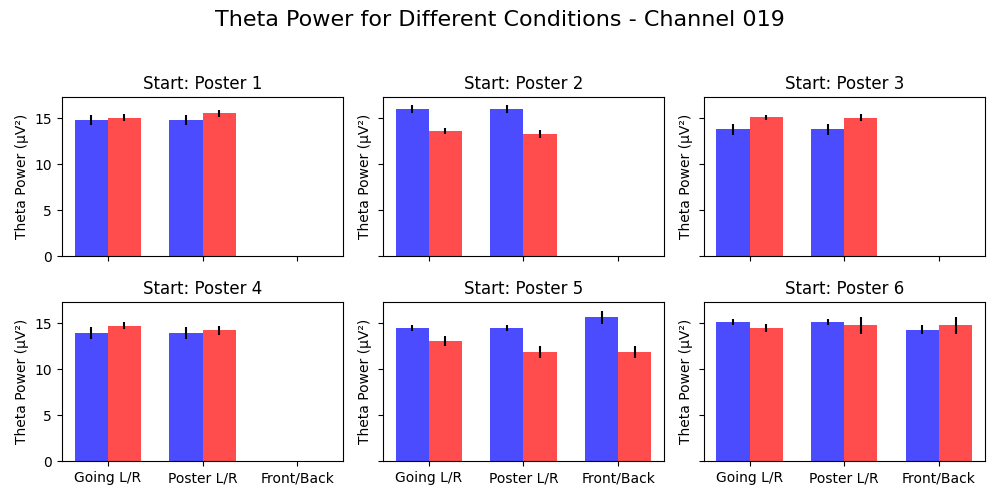

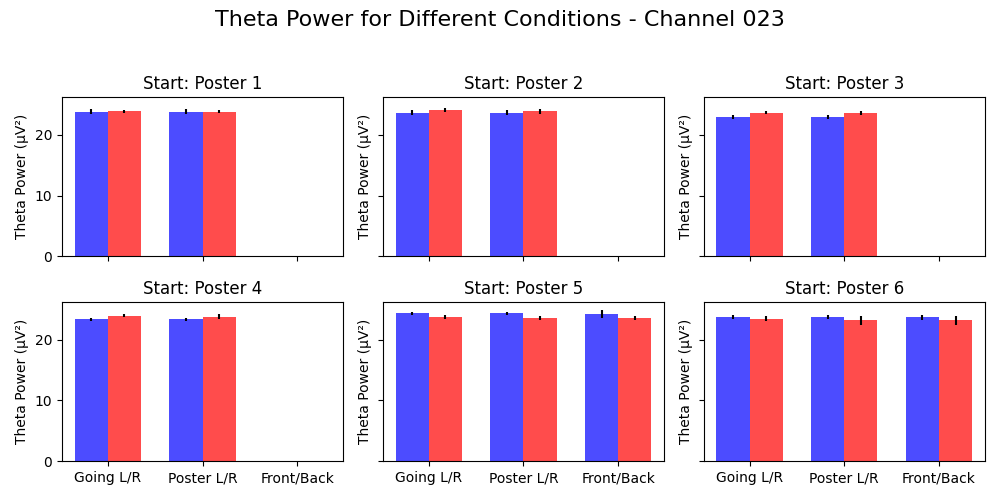

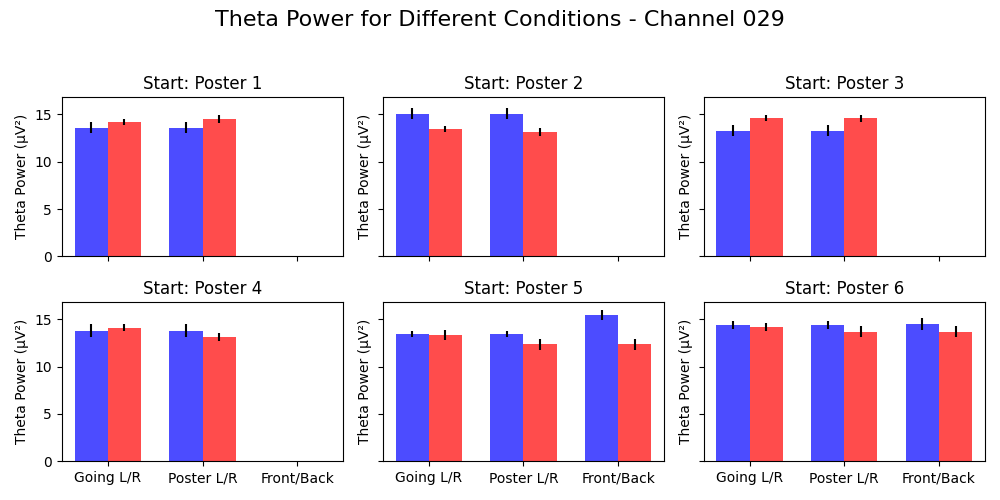

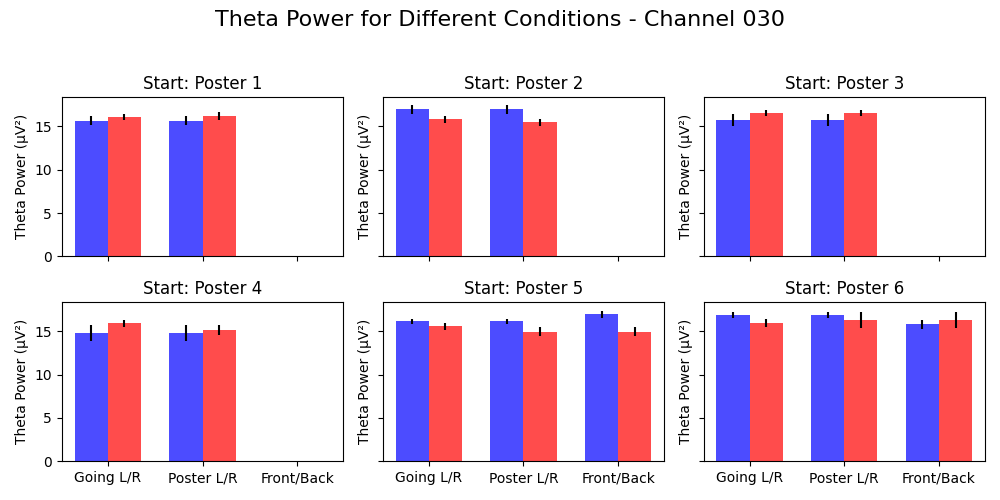

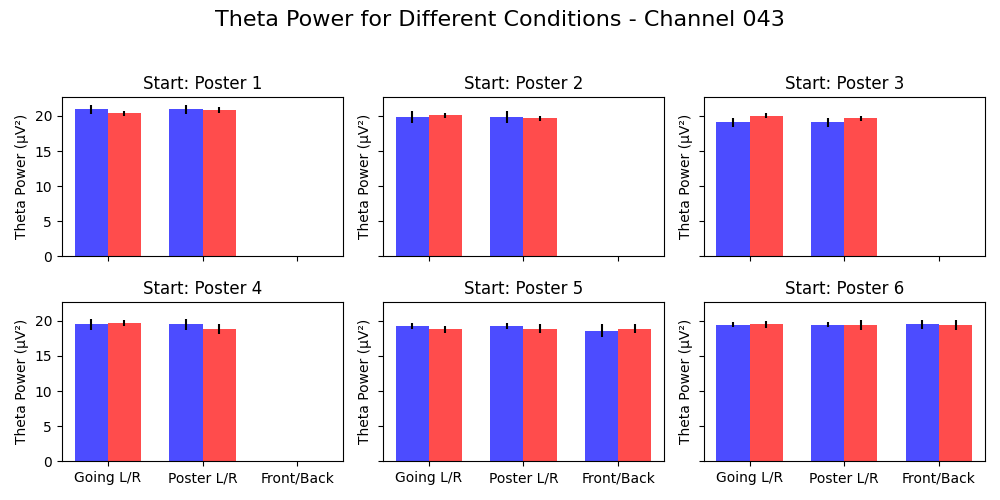

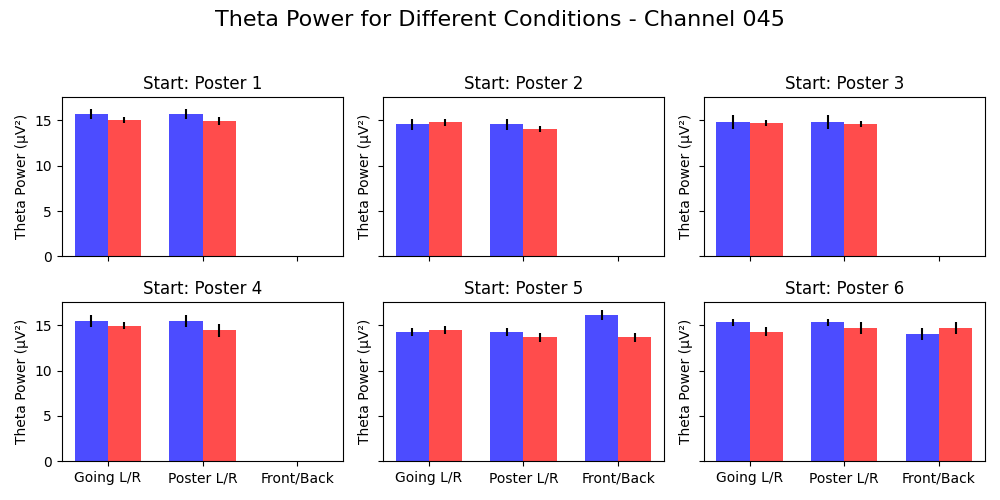

In [29]:
# Define theta frequency range
theta_range = (2, 12)

# Loop through channels of interest
for ch in channels_of_interest:
    # Create a grid of subplots (adjust rows/columns and figsize as needed)
    fig, axes = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
    axes = axes.flatten()
    
    # Loop over each unique start poster position
    for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
        ax = axes[i]
        
        # Initialize lists to store theta power for each condition
        # Condition 1: Going direction (using go_left and go_right)
        going_left = []
        going_right = []
        # Condition 2: Poster position (using left and right)
        poster_left = []
        poster_right = []
        # Condition 3: Relative front/behind (using front and behind)
        front_power = []
        behind_power = []
        
        # Iterate over each unique cue onset
        for cue_onset in np.sort(segments_df['cue_onset'].unique()):
            prev_reward = start_position  # Here, start_position is used as previous reward
            
            # Filter data for the current start poster, channel, and cue onset
            filtered_df = segments_df.loc[
                (segments_df['start_position'] == start_position) &
                (segments_df['channel'] == ch) &
                (segments_df['cue_onset'] == cue_onset)
            ]
            if filtered_df.empty:
                continue

            # Extract PSD and frequency data
            psd_list = filtered_df['psd'].tolist()
            freq_list = filtered_df['freq'].iloc[0][:150]  # assuming freq is consistent
            psd_array = np.array(psd_list)
            
            # Identify theta indices and sum theta power for each trial
            theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
            theta_psd = psd_array[:, theta_indices]
            mean_psd = np.sum(theta_psd, axis=1)
            
            # --- Condition 1: Going Left vs Right ---
            if prev_reward in go_left and cue_onset in go_left[prev_reward]:
                going_left.extend(mean_psd)
            elif prev_reward in go_right and cue_onset in go_right[prev_reward]:
                going_right.extend(mean_psd)
            
            # --- Condition 2: Poster Left vs Right ---
            if prev_reward in left and cue_onset in left[prev_reward]:
                poster_left.extend(mean_psd)
            elif prev_reward in right and cue_onset in right[prev_reward]:
                poster_right.extend(mean_psd)
            
            # --- Condition 3: Front vs Behind ---
            if prev_reward in front and cue_onset in front[prev_reward]:
                front_power.extend(mean_psd)
            elif prev_reward in behind and cue_onset in behind[prev_reward]:
                behind_power.extend(mean_psd)
        
        # Helper function to compute mean and SEM
        def compute_stats(data):
            if len(data) > 0:
                return np.mean(data), sem(data)
            else:
                return np.nan, np.nan
        
        # Compute statistics for each condition pair
        mean_going_left, sem_going_left = compute_stats(going_left)
        mean_going_right, sem_going_right = compute_stats(going_right)
        mean_poster_left, sem_poster_left = compute_stats(poster_left)
        mean_poster_right, sem_poster_right = compute_stats(poster_right)
        mean_front, sem_front = compute_stats(front_power)
        mean_behind, sem_behind = compute_stats(behind_power)
        
        # Prepare the data for grouped bar plotting
        groups = ['Going L/R', 'Poster L/R', 'Front/Back']
        # Each tuple corresponds to the two conditions within a group
        means = [
            (mean_going_left, mean_going_right),    # Going: Left vs Right
            (mean_poster_left, mean_poster_right),   # Poster: Left vs Right
            (mean_front, mean_behind)                # Front: Front vs Behind
        ]
        errors = [
            (sem_going_left, sem_going_right),
            (sem_poster_left, sem_poster_right),
            (sem_front, sem_behind)
        ]
        
        # Define positions for each group on the x-axis
        x = np.arange(len(groups))
        width = 0.35  # width for each bar
        
        # Plot bars for each group with error bars
        for idx, group in enumerate(groups):
            pos = x[idx]
            # For the first condition in each pair (e.g., Left or Front)
            ax.bar(pos - width/2, means[idx][0], width, yerr=errors[idx][0],
                   color='blue', alpha=0.7, label=f'{group} Left' if idx==0 else "")
            # For the second condition in each pair (e.g., Right or Behind)
            ax.bar(pos + width/2, means[idx][1], width, yerr=errors[idx][1],
                   color='red', alpha=0.7, label=f'{group} Right' if idx==0 else "")
        
        ax.set_title(f'Start: Poster {start_position % 10}')
        ax.set_xticks(x)
        ax.set_xticklabels(groups)
        ax.set_ylabel('Theta Power (μV²)')
    
    plt.suptitle(f'Theta Power for Different Conditions - Channel {ch}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind
import pandas as pd

# Define theta frequency range
theta_range = (2, 12)

# Data structure to store t-test results
ttest_results = []

# Specify the start poster and destination posters to compare
start_poster = 31
destinations = [15, 16]

# Loop through channels of interest
for ch in channels_of_interest:
    # Initialize lists for theta power corresponding to each destination
    power_dest3 = []
    power_dest6 = []
    
    # Iterate over the destination conditions (assuming cue_onset codes for destination)
    for dest in destinations:
        # Filter trials for the current channel, start poster, and destination cue
        filtered_df = segments_df.loc[
            (segments_df['start_position'] == start_poster) &
            (segments_df['channel'] == ch) &
            (segments_df['cue_onset'] == dest)
        ]
        
        if filtered_df.empty:
            continue
        
        # Extract PSD and frequency data (assuming frequencies are consistent across trials)
        psd_list = filtered_df['psd'].tolist()
        freq_list = filtered_df['freq'].iloc[0][:150]  # adjust as needed
        psd_array = np.array(psd_list)
        
        # Get indices for theta band
        theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
        theta_psd = psd_array[:, theta_indices]
        
        # Sum theta power within the band for each trial
        mean_psd = np.sum(theta_psd, axis=1)
        
        # Store results in the corresponding list
        if dest == 15:
            power_dest3.extend(mean_psd)
        elif dest == 16:
            power_dest6.extend(mean_psd)
    
    # Compute mean and SEM for each condition
    mean_dest3 = np.mean(power_dest3) if power_dest3 else np.nan
    sem_dest3 = sem(power_dest3) if power_dest3 else np.nan
    mean_dest6 = np.mean(power_dest6) if power_dest6 else np.nan
    sem_dest6 = sem(power_dest6) if power_dest6 else np.nan
    
    # Plot the comparison
    fig, ax = plt.subplots(figsize=(3, 4))
    ax.bar(1, mean_dest3, yerr=sem_dest3, color='blue', alpha=0.7, label='Going to Poster 3')
    ax.bar(2, mean_dest6, yerr=sem_dest6, color='red', alpha=0.7, label='Going to Poster 6')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Poster 3', 'Poster 6'])
    ax.set_ylabel('Theta Power (μV²)')
    ax.set_title(f'Channel {ch} - Start Poster {start_poster}')
    ax.legend(loc="lower right")
    
    # Perform Welch's t-test if both groups have enough data
    if len(power_dest3) > 1 and len(power_dest6) > 1:
        t_stat, p_value = ttest_ind(power_dest3, power_dest6, equal_var=False)
        ttest_results.append({
            'channel': ch,
            'start_poster': start_poster,
            't_stat': t_stat,
            'p_value': p_value
        })
        ax.text(1.5, max(mean_dest3, mean_dest6),
                f't = {t_stat:.2f}\np = {p_value:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Convert t-test results to DataFrame and save if needed
ttest_results_df = pd.DataFrame(ttest_results)
ttest_results_df.to_csv("ttest_results_start1_dest3_vs_6.csv", index=False)
print("T-test results saved to ttest_results_start1_dest3_vs_6.csv")


In [ ]:
# ### im not sure if i can just take the total theta power and just divide by the n?
# ## TODO try getting the range of peaks from peak guess and then getting the peak theta power/n?
# from scipy.stats import sem

# theta_range = (2, 12)

# for ch in channels_of_interest:
#     fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
#     axes = axes.flatten()

#     for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
#         ax = axes[i]

#         for j, cue_onset in enumerate(np.sort(segments_df['cue_onset'].unique())):
#             filtered_df = segments_df.loc[
#                 (segments_df['start_position'] == start_position) &
#                 (segments_df['channel'] == ch) &
#                 (segments_df['cue_onset'] == cue_onset)
#             ]

#             # Ensure there is PSD data to process
#             if filtered_df.empty:
#                 continue

#             # Extract PSD and frequency data
#             psd_list = filtered_df['psd'].tolist()
#             freq_list = filtered_df['freq'].iloc[0][:150]  # Assuming freq is consistent
#             psd_array = np.array(psd_list)

#             # Get indexes for the theta band
#             theta_indices = (freq_list >= theta_range[0]) & (freq_list <= theta_range[1])
            
#             theta_psd = psd_array[:, theta_indices]

#             mean_psd = np.mean(theta_psd, axis=1)  # Mean power within the theta band for each trial
#             mean_theta_power = np.mean(mean_psd)  # Mean across all trials
#             sem_theta_power = sem(mean_psd)  # SEM across all trials

#             # Plot mean and SEM
#             ax.bar(j, mean_theta_power, yerr=sem_theta_power, label=f'Cue {cue_onset}', alpha=0.7)

#         # Customize subplot
#         ax.set_title(f'Start Position {start_position}')
#         ax.set_xlabel('Cue Onset')
#         ax.set_ylabel('Theta Power (u/V^2)')
#         ax.legend(loc="lower behind")

#     # Adjust layout and add a main title
#     plt.suptitle(f'Trial Averaged Theta Power for Channel {ch} (2-12 Hz)')
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()


In [ ]:
# Extract the first, second, and third peaks
first_peaks = segments_df['peak_freqs'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
second_peaks = segments_df['peak_freqs'].apply(lambda x: x[1] if len(x) > 1 else np.nan)
third_peaks = segments_df['peak_freqs'].apply(lambda x: x[2] if len(x) > 2 else np.nan)

# Drop NaN values for each peak set
first_peaks = first_peaks.dropna()
second_peaks = second_peaks.dropna()
third_peaks = third_peaks.dropna()

# Filter the peaks to include only values between 2 and 12 Hz
first_peaks_filtered = first_peaks[(first_peaks >= 2) & (first_peaks < 12)]
second_peaks_filtered = second_peaks[(second_peaks >= 2) & (second_peaks < 12)]
third_peaks_filtered = third_peaks[(third_peaks >= 2) & (third_peaks < 12)]

# Define bin edges from 2 to 12 in 1 Hz intervals
bins = np.arange(2, 13, 1)  # This creates bins: [2-3), [3-4), ..., [11-12)

# Plot distributions with filtered data
plt.figure(figsize=(10, 5), dpi=150)

# First peaks
plt.subplot(1, 3, 1)
plt.hist(first_peaks_filtered, bins=bins, alpha=0.7)
plt.title('First Peaks Distribution')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count')
plt.xticks(bins)  # Set x-axis ticks at 1 Hz intervals

# Second peaks
plt.subplot(1, 3, 2)
plt.hist(second_peaks_filtered, bins=bins, alpha=0.7)
plt.title('Second Peaks Distribution')
plt.xlabel('Frequency (Hz)')
plt.xticks(bins)

# Third peaks
plt.subplot(1, 3, 3)
plt.hist(third_peaks_filtered, bins=bins, alpha=0.7)
plt.title('Third Peaks Distribution')
plt.xlabel('Frequency (Hz)')
plt.xticks(bins)

plt.tight_layout()
plt.show()


In [ ]:
# TODO: i need to do anova on each starting position against cue poster. behind now its looking only at the starting position?

# Define theta range
theta_range = (2, 12)

# Data structures to store ANOVA and Post-Hoc results
anova_results = []
posthoc_results = []

for ch in channels_of_interest:
    # Plot setup for each channel
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start_position in enumerate(np.sort(segments_df['start_position'].unique())):
        ax = axes[i]
        first_peak_by_cue = {}  # Store first peak frequencies grouped by cue onset
        all_first_peaks = []
        all_cue_labels = []

        for j, cue_onset in enumerate(np.sort(segments_df['cue_onset'].unique())):
            # Filter DataFrame for current start position, channel, and cue onset
            filtered_df = segments_df.loc[
                (segments_df['start_position'] == start_position) &
                (segments_df['channel'] == ch) &
                (segments_df['cue_onset'] == cue_onset)
            ]

            # Ensure there is peak frequency data to process
            if filtered_df.empty or 'peak_freqs' not in filtered_df.columns:
                continue

            # Extract the first peak frequency
            first_peaks = filtered_df['peak_freqs'].apply(lambda x: x[0] if len(x) > 0 else np.nan).dropna()

            # Filter the peaks to include only values between 2 and 12 Hz (theta range)
            first_peaks_filtered = first_peaks[(first_peaks >= theta_range[0]) & (first_peaks < theta_range[1])]

            if first_peaks_filtered.empty:
                continue

            # Store first peak data for ANOVA
            first_peak_by_cue[cue_onset] = first_peaks_filtered.values
            all_first_peaks.extend(first_peaks_filtered.values)
            all_cue_labels.extend([cue_onset] * len(first_peaks_filtered))

            # Compute mean and SEM for plotting
            mean_first_peak = np.mean(first_peaks_filtered)
            sem_first_peak = sem(first_peaks_filtered)

            # Plot mean and SEM
            ax.bar(j + 1, mean_first_peak, yerr=sem_first_peak, label=f'Cue {cue_onset}', alpha=0.7)

        # Customize subplot
        ax.set_title(f'Start: Poster {start_position % 10}')
        ax.set_xlabel('Cue Poster')
        ax.set_ylabel('First Peak Frequency (Hz)')
        ax.set_xticks(np.arange(1, len(np.unique(segments_df['cue_onset'])) + 1, 1))
        ax.legend(loc="lower right", fontsize='small')

        # Perform ANOVA if there are at least two cue groups
        if len(first_peak_by_cue) > 1:
            f_stat, p_value = f_oneway(*first_peak_by_cue.values())
            anova_results.append({
                'channel': ch,
                'start_position': start_position,
                'f_stat': f_stat,
                'p_value': p_value
            })

            # Perform post-hoc Tukey HSD if ANOVA is significant
            if p_value < 0.05:
                tukey_result = pairwise_tukeyhsd(endog=all_first_peaks,
                                                 groups=all_cue_labels,
                                                 alpha=0.05)

                # Store post-hoc results
                for res in tukey_result.summary().data[1:]:  # Skip header
                    posthoc_results.append({
                        'channel': ch,
                        'start_position': start_position,
                        'group1': res[0],
                        'group2': res[1],
                        'mean_diff': res[2],
                        'p_adj': res[3],
                        'lower': res[4],
                        'upper': res[5],
                        'reject': res[6]
                    })

    # Adjust layout and add main title
    plt.suptitle(f'First Peak Frequency Across Cue Posters for Channel {ch}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Convert ANOVA results to DataFrame
anova_results_df = pd.DataFrame(anova_results)
posthoc_results_df = pd.DataFrame(posthoc_results)

# Save results to CSV files
anova_results_df.to_csv("anova_results_first_peak.csv", index=False)
posthoc_results_df.to_csv("posthoc_results_first_peak.csv", index=False)

print("ANOVA results saved to anova_results_first_peak.csv")
print("Post-hoc Tukey results saved to posthoc_results_first_peak.csv")

# Display significant post-hoc results
significant_posthoc = posthoc_results_df[posthoc_results_df['reject'] == True]
print("\nSignificant Post-Hoc Results: \n", significant_posthoc)
